<a href="https://colab.research.google.com/github/SeungHan0816/WM-811k_Wafermap_Practice/blob/main/WM_811k_Wafermap_Practice01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# (이 셀을 실행해야 Kaggle 데이터 소스를 가져올 수 있습니다.)
# THEN FEEL FREE TO DELETE THIS CELL.
# (이후에는 이 셀을 삭제해도 괜찮습니다.)
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
# (참고: 이 노트북 환경은 KAGGLE의 Python 환경과 다르므로)
# (노트북에서 사용하는 라이브러리가 누락되었을 수 있습니다.)

import kagglehub
# kagglehub.dataset_download()는 qingyi/wm811k-wafer-map이라는 Kaggle 데이터셋을 다운로드하는 함수
qingyi_wm811k_wafer_map_path = kagglehub.dataset_download('qingyi/wm811k-wafer-map')

print('Data source import complete.')


Data source import complete.


반도체 산업에서 머신러닝이 어떻게 사용되는지 보여준다.

목적 : wafer map의 failure pattern(고장 패턴)을 수동작업 대신 자동으로 identify(식별)한다. 이를 통해, 반도체 생산에서 제조과정의 수율을 개선한다.

input : kaggle WM-811K dataset

Model : one vs one 다중 클래스 분류 모델 영상 감지 시스템(다중 클래스를 가진 데이터를 서로 다른 클래스를 가지는 데이터로 쪼개고 이를 이진 분류기로 학습)

output : Failure pattern labels(고장 패턴 라벨)

In [ ]:
# 라이브러리 불러오기

# numpy: 수치 계산을 위한 대표적인 과학 계산 라이브러리
# pandas: 표 형태의 데이터를 쉽게 다룰 수 있게 해주는 도구
# matplotlib.pyplot: 데이터를 시각화하는 데 사용되는 라이브러리
import numpy as np # linear algebra(선형대수)
import pandas as pd # data processing, CSV file I/O(데이터 처리, CSV 파일 입출력)
import matplotlib.pyplot as plt

# # 코랩이나 주피터 노트북에서 그래프를 코드 아래에 바로 보여주게 해주는 설정
# 일반 Python에서는 안 쓰고, 노트북 환경에서만 사용하는 특수 명령어
%matplotlib inline

import os # 운영체제 관련 기능을 다루는 라이브러리(파일 경로나 폴더 등을 다루고 싶을 때 사용)

# ../input이라는 폴더(= 상위 폴더의 input 디렉토리)에 있는 파일/폴더 목록을 출력
# os.listdir()은 디렉토리 내부 파일 목록을 리스트로 반환
# ../input은 아마도 데이터셋이 저장된 경로일 가능성이 높음.(qingyi_wm811k_wafer_map_path)
print(qingyi_wm811k_wafer_map_path)
print(os.listdir(qingyi_wm811k_wafer_map_path))

# 경고 메시지를 출력하지 않도록 설정(실수나 오류는 아니지만, 방해가 될 수 있는 경고들을 숨김.)
import warnings
warnings.filterwarnings("ignore")

# /kaggle/input/wm811k-wafer-map -> Kaggle에서 다운로드된 데이터 폴더의 전체 경로
# ['LSWMD.pkl']	-> 그 폴더 안에 있는 파일 이름. LSWMD.pkl 하나만 존재


/kaggle/input/wm811k-wafer-map
['LSWMD.pkl']


data 고르기 & 전처리 : 어떤 데이터가 사용가능이고, 어떤 데이터가 손실되어있고 어떤 데이터를 지워도 되는지 고민하기. 또한, 선택한 데이터를 formatting(서식 설정), cleaning(데이터 정리), sampling(표본 추출)을하여 구성한다.

- Data summary(데이터 요약)
- Target distribution(대상 분포)
- Missing value check(누락 값 확인)
- Others(기타)

In [ ]:
# Data summary(데이터 요약:지금부터 데이터를 로딩하고 어떤 형식인지 요약 정보를 확인)

# os.path.join(...)	-> 경로 + 파일명을 합쳐주는 안전한 방법
# qingyi_wm811k_wafer_map_path -> 아까 kagglehub로 다운로드한 실제 데이터 폴더 경로
# "LSWMD.pkl"	-> 실제로 존재하는 파일명
# read_pickle(...) -> 이 파일을 열어 Python 객체로 변환
# LSWMD.pkl이라는 피클(pickle) 파일을 열어 내용을 꺼냄
df=pd.read_pickle(os.path.join(qingyi_wm811k_wafer_map_path, "LSWMD.pkl"))

df.info() # df가 어떤 데이터를 담고 있는지 구조 요약을 출력

# 총 샘플 수	811,457개
# 총 열(Column) 수	6개
# 용량	약 37.1MB
# 결측치	없음 (모든 열이 811,457개로 동일)

# waferMap (타입: object) -> 웨이퍼의 2D 맵 이미지 데이터
# 실제로는 2차원 배열(np.array) 또는 리스트 내부에 이미지 같은 행렬 데이터가 들어 있음
# 따라서 object 타입이지만, 내용은 배열 형태

# dieSize (타입: float64) -> 하나의 웨이퍼에 몇 개의 다이(Die)가 있는지 나타내는 크기 정보
# 다이는 반도체 조각의 최소 단위

# lotName (타입: object) -> 웨이퍼 생산 로트 이름
# 알파벳과 숫자가 섞인 문자열

# waferIndex (타입: float64) -> 웨이퍼 번호 (고유 인덱스)
# 한 로트 내에서 어떤 번호인지 나타내는 숫자

# trianTestLabel (타입: object) -> 이 열은 각 샘플이 학습용(train)인지 테스트용(test)인지 나타냄

# failureType (타입: object) -> 웨이퍼 불량 유형 (정상일 수도 있음)
# 예: 'Center', 'Donut', 'Loc', 'Edge-Loc', 'None' 등
# 이 열이 레이블(label) 역할 -> 우리가 분류하려는 목표 값


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


- 이 dataset은 dieSize, lotName, waferIndex 등의 정보와 811457개의 wafermap으로 이루어져있다.
- 훈련set, 테스트set 모두 이미 전문가에 의해 분류가 되어있다. 하지만 여기에서는 무시를 하고 새롭게 재설계를 하였다.



In [ ]:
# Target distribution(타겟(레이블)의 분포를 확인)

# head() 함수는 기본적으로 앞에서부터 5개의 행(row) 을 출력
# (df 안에 어떤 값들이 들어있는지 간단히 미리 확인)
df.head()

# [[Training]] ← 특이한 구조! (이중 리스트 형태로 저장되어 있음)
# 정제(preprocessing)할 때 리스트 안에서 문자열 꺼내서 평탄화(flatten)해야 함.

# [[none]] ← 이것도 이중 리스트(고장 유형이 없는 경우에도 '[[none]]' 형태)
# 문자열로 꺼내야 함.

# 예시 : df['trianTestLabel'] = df['trianTestLabel'].apply(lambda x: x[0][0])
# 예시 : df['failureType'] = df['failureType'].apply(lambda x: x[0][0])

# df['trianTestLabel'] -> 한 열(Series)을 선택
# .apply(...) -> 각 행(row)의 값 하나하나에 함수(function)를 적용
# lambda x: x[0][0] -> 값을 꺼내기 위한 익명 함수
# x -> 각 행의 값 ([['Training']])

# Suggest charts” 자동 그래프는 matplotlib를 직접 사용한 게 아니고
# Colab이 알아서 뽑아준 시각화입니다.(이 기능은 참고용 무시해도 전혀 문제 없음.)
# matplotlib, pandas, seaborn 같은 걸로 필요한 그래프 직접 만들어 쓰는 게 정답임.


,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


In [ ]:
# pandas.DataFrame 객체에서 뒤쪽 5개의 행(row) 을 보여주는 함수
# df.head()가 처음 5개, df.tail()은 마지막 5개를 보여줌
df.tail()

# []는 "라벨이 원래 없는 샘플" -> 학습용이 아니라 예측 대상

# Suggest charts” 자동 그래프는 matplotlib를 직접 사용한 게 아니고
# Colab이 알아서 뽑아준 시각화입니다.(이 기능은 참고용 무시해도 전혀 문제 없음.)
# matplotlib, pandas, seaborn 같은 걸로 필요한 그래프 직접 만들어 쓰는 게 정답임.


,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]
811456,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47543,2.0,[],[]


- 이 dataset은 fab의 47543개의 실제 lots(wafer 25장짜리 세트)에서 모였다.
- 하지만 47543개의 lots에는 wafer가 47543*25=1557325개인데, 이는 811457개의 wafer map 갯수보다 큰 값이다. -> 데이터를 뜯어보자.

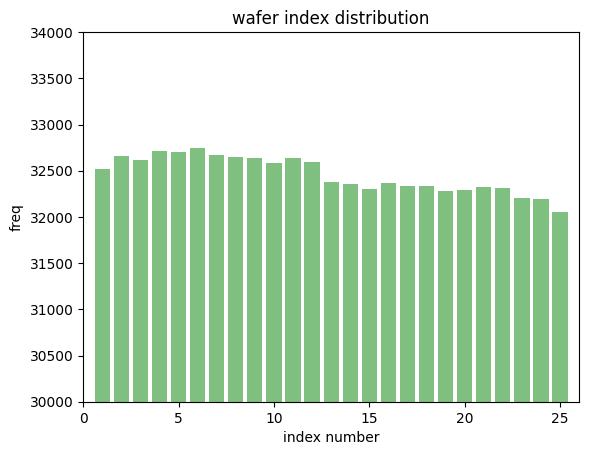

25개 미만인 lot 수: 24531
25개 미만인 lot 비율: 52.99%


In [ ]:
import matplotlib.pyplot as plt
# 노트북에서 그래프를 셀 아래에 출력하는 Jupyter 전용 명령어
# %matplotlib inline은 매직 명령어 -> 한 줄만 단독으로 써야 함.
%matplotlib inline

# df.waferIndex -> 웨이퍼 번호들 (float형 번호: 1.0, 2.0, ..., 25.0 등)
# np.unique(..., return_counts=True) -> 각 웨이퍼 인덱스 값별로 몇 번 등장했는지
# np.unique(배열) -> 배열 안에서 중복을 제거한 고유한 값들만 뽑아줌
# np.unique(배열, return_counts=True) -> 고유한 값들과 함께, 그 값들이 몇 번 나왔는지(빈도 수)도 같이 알려줌

# uni_Index[0] → 유일한 웨이퍼 번호 (예: [1.0, 2.0, ..., 25.0])
# uni_Index[1] → 각 번호의 등장 횟수 (예: [32614, 32984, ..., 32815])
uni_Index=np.unique(df.waferIndex, return_counts=True)

# 막대 그래프(bar chart)를 그림, x축: waferIndex 값, y축: 빈도 수 (몇 번 나왔는지)
# alpha=0.5: 투명도 설정 (0 = 완전 투명, 1 = 불투명)
plt.bar(uni_Index[0],uni_Index[1], color='green', align='center', alpha=0.5)

# 그래프 제목과 축 라벨 설정
plt.title("wafer index distribution")
plt.xlabel("index number")
plt.ylabel("freq")

# x축, y축 범위 지정
# 웨이퍼 인덱스는 1 ~ 25 사이 -> x축 0~26으로 보기 좋게
# 빈도 수는 대략 3만 개 정도 → 30000~34000으로 확대해서 패턴 보기 쉽게
plt.xlim(0,26)
plt.ylim(30000,34000)

plt.show() # 그래프 출력

# lot별 wafer 개수 세기
# 한 열 안에 들어 있는 값들이 각각 몇 번씩 등장했는지(빈도수)를 자동으로 세어주는 함수
# 열: 특성(속성) 하나의 값들이 많음 → 빈도 분석 적합
# 행: 한 줄에 모든 정보가 담겨 있음 → 빈도 분석에 부적절
lot_counts = df['lotName'].value_counts()

# 25개 미만인 lot 개수 세기
incomplete_lots = (lot_counts < 25).sum()
print("25개 미만인 lot 수:", incomplete_lots)

# 그 비율도 보기
percent = (lot_counts < 25).mean() * 100
print(f"25개 미만인 lot 비율: {percent:.2f}%")


- 배열로 들어있는 상태에서 np.unique와 return_counts=True로 고윳값 갯수 추출
- uni_Index[0]과 [1]에 index와 그 갯수가 각각 들어가있고, 이를 bar 그래프로 그려낸다

- 결과적으로 봤을때, 각 lots에 25개씩의 wafer map이 있는 것은 아니라는 것을 알 수 있다.. 이는 sensor failure(센서 고장)나 다른 안알려진 문제 때문일 수 있다.
- 우리의 분류에서는 wafer index feature(웨이퍼 인덱스 기능)는 필요가 없고 drop the variable(변수 제거)만 하면 된다.

In [ ]:
# df -> 기존의 DataFrame 객체 (2차원 표) -> 다시 df에 저장(덮어쓰기)
# .drop([...]) -> 특정 열 또는 행을 삭제하라는 명령
# ['waferIndex'] -> 삭제할 열의 이름 목록 (리스트 형태)
# axis=1 -> 열 기준 삭제 (세로축 삭제)라는 뜻
df=df.drop(['waferIndex'], axis=1)


In [ ]:
# 위 코드를 두 번 실행하면 keyError가 발생함!(이미 지운걸 또 지우려 하니 발생한 오류)
# 그러니 위 코드 실행보다 밑에 있는 코드를 실행하면 더 쉽게 지워졌는지 알 수 있음!

if 'waferIndex' in df.columns:
  df = df.drop(['waferIndex'], axis=1)
else:
  print("waferIndex 열이 이미 삭제되었습니다.")

# 열 이름이 없는지 확인
print(df.columns)


waferIndex 열이 이미 삭제되었습니다.
Index(['waferMap', 'dieSize', 'lotName', 'trianTestLabel', 'failureType'], dtype='object')


- 다이 사이즈가 다 다르다는 것을 알 수 있다.
- 그래서 새로운 변수 'waferMapDim'을 만들어서 사용하자.

In [ ]:
def find_dim(x):
    dim0=np.size(x, axis=0) # 행 개수
    dim1=np.size(x, axis=1) # 열 개수
    return dim0, dim1 # (행, 열) 튜플로 리턴
df['waferMapDim']=df.waferMap.apply(find_dim) # waferMap 열의 각 원소에 find_dim(x) 함수를 하나씩 적용
df.sample(5) # 무작위 5개 샘플을 출력


,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
285350,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4096.0,lot17429,[],[],"(72, 72)"
704067,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,...",516.0,lot43187,[[Training]],[[none]],"(25, 27)"
643361,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,...",533.0,lot40477,[[Test]],[[none]],"(26, 26)"
336973,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",912.0,lot20292,[],[],"(34, 35)"
182842,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2000.0,lot11650,[],[],"(49, 53)"


In [ ]:
# max(df.waferMapDim) -> (행, 열) 튜플 중 가장 큰 튜플 (행 기준)
# min(df.waferMapDim) -> 가장 작은 튜플 (행 기준)
# 튜플끼리 크기를 비교하면 첫 번째 요소(행)를 우선 기준으로 비교
max(df.waferMapDim), min(df.waferMapDim)


((300, 202), (6, 21))

In [ ]:
# df.waferMapDim은 (행, 열) 형태의 튜플
# np.unique()는 중복 제거된 고유한 값들을 반환
# return_counts=True를 붙이면 -> 첫 번째 결과: 고유한 값 리스트, 두 번째 결과: 각 값의 등장 횟수(빈도)
# uni_waferDim = (고유한 튜플 배열, 각 튜플의 등장 횟수 배열)
uni_waferDim=np.unique(df.waferMapDim, return_counts=True)

# uni_waferDim[0] -> 고유한 크기 조합들
# uni_waferDim[1] -> 각각 몇 번 나왔는지
# uni_waferDim[0].shape[0] -> 고유한 (행, 열) 조합이 몇 종류인지 구하기
uni_waferDim[0].shape[0]


632

- wafer map의 dimension의 min, max 값이 다른걸 보았을때 size가 다 다르다는 것을 알 수 있었다.

- 또한 632개의 다른 size가 있음을 알 수 있었음.

- waferMapDim에 여러 개의 (행, 열) 튜플이 있고
np.unique()로 중복 없이 고유한 값만 남기면,
서로 다른 shape(크기)의 종류 수만 남는데 그 결과 값이 632임.(632종류)

이제 결측 데이터를 확인해볼 차례이다

- 결측치로 인하여 쓸모없는 값이 되어버릴 수 있다.
- 결측치를 확인하는 것은 데이터 전처리 과정에서 매우 중요하다.
- 애초에 우리는 패턴이 있는 wafer에만 관심이 있기 때문에 failure type label(고장 유형 라벨)이 없는 데이터를 지울 수 있다.

In [ ]:
# 기존 문자열 열을 건드리지 않고, 새로운 열로 만든 것 -> 원본 보존하면서 숫자 라벨 추가
# failureNum -> 고장 유형(failureType)을 숫자로 바꾼 열
# trainTestNum -> 학습/테스트 구분을 숫자로 바꾼 열
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel

# 결함 종류(failure type)를 숫자 ID로 바꿔주는 딕셔너리(머신러닝에서 Label Encoding 또는 정수 인코딩)
mapping_type={'Center':0, 'Donut':1, 'Edge-Loc':2, 'Edge-Ring':3, 'Loc':4, 'Random':5,'Scratch':6, 'Near-full':7, 'none':8}

# trianTestLabel의 값도 Training -> 0, Test -> 1로 변환할 준비
mapping_traintest={'Training':0, 'Test':1}

# df['failureNum']에서 문자열을 숫자로 바꿈('Edge-Loc' → 2 등)
# df['trainTestNum']에서도 문자열을 숫자로 바꿈('Training' → 0 등)
# replace()는 자동으로 매핑 딕셔너리를 찾아서 변환
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})


In [ ]:
# 현재 데이터프레임(df)에 몇 개의 웨이퍼 샘플(행)이 있는지 확인하는 작업
# df.shape	(행 개수, 열 개수)를 튜플로 반환
# df.shape[0]	첫 번째 값, 즉 행의 수만 가져옴
# tol_wafers	→ 이걸 변수에 저장 (전체 웨이퍼 수)
tol_wafers=df.shape[0] # 행 갯수 반환
tol_wafers

# 각 웨이퍼 하나당 waferMap, failureType, trianTestLabel 등 하나의 행에 저장
# 한 행 = 한 개의 웨이퍼이기에 행 수 = 웨이퍼 개수이다.


811457

In [ ]:
# WM-811K 데이터셋에서 결함 유무와 결함 종류에 따라 데이터를 세 그룹으로 나눈 것

# df_withlabel -> 모든 레이블이 있는 샘플 (결함 + 정상 포함) -> failureNum ∈ [0 ~ 8]
# failureNum 값이 0~8 사이인 모든 샘플 선택(결함 유형(0~7) + 결함 없음(none, 8) 모두 포함)
# reset_index()로 인덱스를 새로 설정 (기존 index 제거)
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)] # 새로운 데이터 프레임 생성
df_withlabel = df_withlabel.reset_index() # 앞에서 생성한 데이터 프레임의 인덱스 재설정

# df_withpattern -> 결함 패턴이 있는 샘플만 -> failureNum ∈ [0 ~ 7]
# failureNum 값이 0~7 -> 실제 결함이 있는 웨이퍼들만(딥러닝 모델에서 결함 패턴 인식용 데이터로 주로 사용)
# reset_index()로 인덱스를 새로 설정 (기존 index 제거)
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)] # 새로운 데이터 프레임 생성
df_withpattern = df_withpattern.reset_index() # 데이터 프레임 인덱스 재설정

# df_nonpattern -> 결함이 없는 정상 샘플만 -> failureNum == 8
# failureNum == 8 -> 'none' (정상 샘플만 분리)
# df_withlabel.shape[0] -> 레이블이 지정된 모든 샘플 개수
# df_withpattern.shape[0] -> 결함이 있는 샘플 수
# df_nonpattern.shape[0] -> 결함이 없는(정상) 샘플 수
df_nonpattern = df[(df['failureNum']==8)] # 새로운 데이터 프레임 생성
df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0] # 각 데이터 프레임 행 갯수 반환

# 원래 df에서의 인덱스를 유지한 인덱스가 1, 2, ...로 남은 reset_index()을 써서
# 다시 0부터 1씩 증가하게 재정렬하게 하는 것.(필터링/샘플링 후 인덱스가 중구난방일 때 정리하기 위해)

# reset_index() -> 인덱스를 초기화하고, 기존 인덱스는 새로운 열로 보관
# reset_index(drop=True) -> 인덱스 초기화 + 기존 인덱스 완전히 삭제

# 172950 -> 전체 라벨이 붙은 샘플 수 (결함 있는 + 정상) -> df_withlabel.shape[0]
# 25519 -> 결함 있는 웨이퍼 수 (패턴 존재) -> df_withpattern.shape[0]
# 147431 -> 정상 웨이퍼 수 (패턴 없음, 'none') -> df_nonpattern.shape[0]

# 이걸 기반으로 결함 비율 계산이나 클래스 불균형 분석, 또는 데이터 리샘플링 작업도 가능


(172950, 25519, 147431)

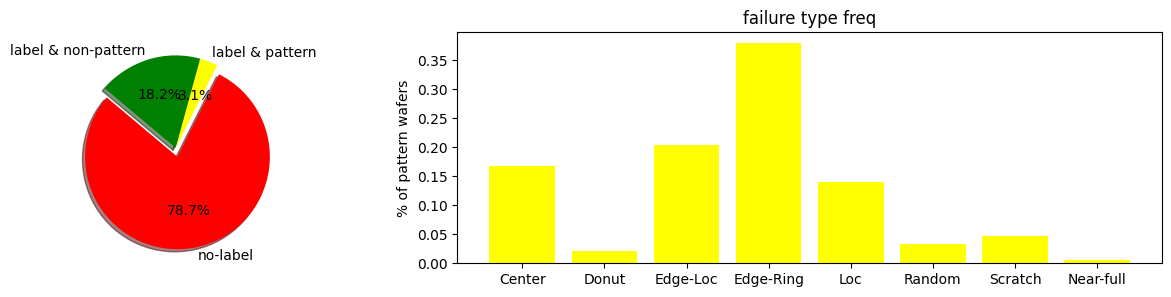

In [ ]:
# WM-811K 데이터셋을 두 가지 시각화

import matplotlib.pyplot as plt
%matplotlib inline

# gridspec: 서브플롯(두 개 그래프)을 비율 다르게 나눌 수 있게 도와주는 툴
from matplotlib import gridspec

figure = plt.figure(figsize=(15,3)) # 전체 그림 사이즈 설정
gridspec = gridspec.GridSpec(1, 2, width_ratios=[1,2]) # 1행 2열로, 비율 1:2로 나눔
ax1 = plt.subplot(gridspec[0]) # 파이 차트 (ax1) -> 레이블 없는 샘플 / 결함 샘플 / 정상 샘플의 비율
ax2 = plt.subplot(gridspec[1]) # 막대 차트 (ax2) -> 결함 유형별 분포 비율 (0~7번 클래스)

# shape[0] → 행 개수 (샘플 수)

# tol_wafers: 전체 웨이퍼 수
# df_withlabel.shape[0]: 라벨이 있는 웨이퍼 수
# tol_wafers - df_withlabel.shape[0]는 라벨이 없는 샘플 수(전체 - 라벨 있는 웨이퍼 = 라벨 없는 웨이퍼)

# df_withpattern.shape[0]: 결함 있는 웨이퍼 수
# df_nonpattern.shape[0]: 정상(패턴 없음) 웨이퍼 수
no_wafers=[tol_wafers-df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]]

colors = ['red', 'yellow', 'green'] # colors: 각각 빨강(라벨 없음), 노랑(결함 있음), 초록(정상)

# 첫 번째 조각은 0.1만큼 밖으로 분리됨 (툭 튀어나옴), 나머지 조각은 분리되지 않음 (0) -> 시각적으로 강조
# explode: 첫 조각을 좀 더 바깥으로 튀어나오게
explode = (0.1, 0, 0)
labels = ['no-label', 'label & pattern', 'label & non-pattern'] # 각 색별로 명칭 지정

# %1.1f%%는 소수점 한 자리까지 퍼센트를 보임.(각 조각에 비율을 표시해주는 옵션)
# shadow=True -> 그림자 효과를 켜주는 옵션

# startangle=140 -> 파이 차트를 몇 도부터 시작해서 그릴지 정하는 각도 기본은 0도 (오른쪽부터 시작)
# 140도는 왼쪽 아래 방향쯤에서 시작(기준 위치를 회전시켜서 보기 좋게 배치하기 위해 사용)
ax1.pie(no_wafers, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)



# df_withpattern.failureNum -> df_withpattern 데이터프레임에서 failureNum 열(결함 유형 번호)을 뽑아냄
# return_counts=True -> 중복을 제거한 고유 값만 정렬해서 추출
# 튜플(고유번호 배열, 빈도수 배열)로 반환

# uni_pattern[0] → 고유한 결함 번호들 (예: [0 1 2 3 4 5 6 7])
# uni_pattern[1] → 각 번호가 나온 횟수 (예: [5000, 7000, ...])
uni_pattern=np.unique(df_withpattern.failureNum, return_counts=True)

# 0 -> '' -> 사용되지 않음 (공백)
# 1 -> 'Center' -> 중심 결함
# 2 -> 'Donut' -> 도넛형 결함
# 3 -> 'Edge-Loc' -> 가장자리 위치 결함
# 4 -> 'Edge-Ring' -> 가장자리 링 결함
# 5 -> 'Loc' -> 특정 위치 결함
# 6 -> 'Random' -> 랜덤한 결함
# 7 -> 'Scratch' -> 긁힘 결함
# 8 -> 'Near-full' -> 거의 전체 결함
labels2=['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

# ax2.bar(...) -> bar(): matplotlib의 막대그래프 함수, ax2: 막대그래프를 그릴 좌측 subplot 객체
# uni_pattern[0] -> df_withpattern.failureNum의 고유한 값(결함 번호들), 예: [0 1 2 3 4 5 6 7]
# x축 위치 (막대의 카테고리 번호)를 나타냄

# uni_pattern[1]/df_withpattern.shape[0] -> uni_pattern[1]: 각 결함 번호의 발생 횟수 (예: [500, 200, ...])
# df_withpattern.shape[0]: 결함 웨이퍼의 총 수
# 이를 나누면 각 결함 번호가 전체에서 차지하는 비율(%)이 됨 -> 막대의 높이(y축)

# align='center' -> 막대를 중심 정렬 (기본값)
# alpha=1 -> 투명도 설정: 1은 완전 불투명 (0이면 완전 투명)
ax2.bar(uni_pattern[0],uni_pattern[1]/df_withpattern.shape[0], color='yellow', align='center', alpha=1)

# ax2 제목 -> failure type freq로 설정(결함 유형 빈도수)
ax2.set_title("failure type freq")

# y축 라벨 설정 -> 결함 웨이퍼 중 각 결함의 비율
ax2.set_ylabel("% of pattern wafers")

# 주의할 점: set_xticklabels()을 쓸 때는 set_xticks()를 같이 써줘야 할 때 많음.
# (안 그러면 눈금 개수와 이름 개수가 안 맞아서 경고 메시지가 뜰 수 있음)
ax2.set_xticklabels(labels2) # x축 눈금 숫자 위치에 대응하는 labels2 이름들을 붙여줌.

plt.show()

# uni_pattern[0]은 막대는 실제로 이 숫자 위치(0~7)에 그려짐
# ax2.set_xticklabels(labels2)이걸로 숫자 위치 0~8에 대응하는 labels2 이름들을 붙여줌.
# (위치 인덱스를 기반으로 문자 레이블을 지정하는 것)


- 결과를 보면, 172950개의 wafer는 라벨링이 되어있음. 하지만 78.7%의 나머지 wafer는 라벨링이 되어있지 않음.

- 라벨링된 wafer 중에, 3.1%인 25519개의 wafer는 failure pattern(고장 패턴)을 가지고 있지만 나머지 147431개의 wafer는 여전히 그대로 있음.

- **결국 우리는 25519개에만 집중을 해야할거같음
(결함 있는 웨이퍼 수 (패턴 존재) -> df_withpattern).**

- failure type(고장 패턴)은 다양

- 데이터를 좀 한눈에 보기 위해 데이터 시각화를 해봐야할거같다.
- 라벨링 되어있는 애들로 몇개 골라서 한 번 보자.

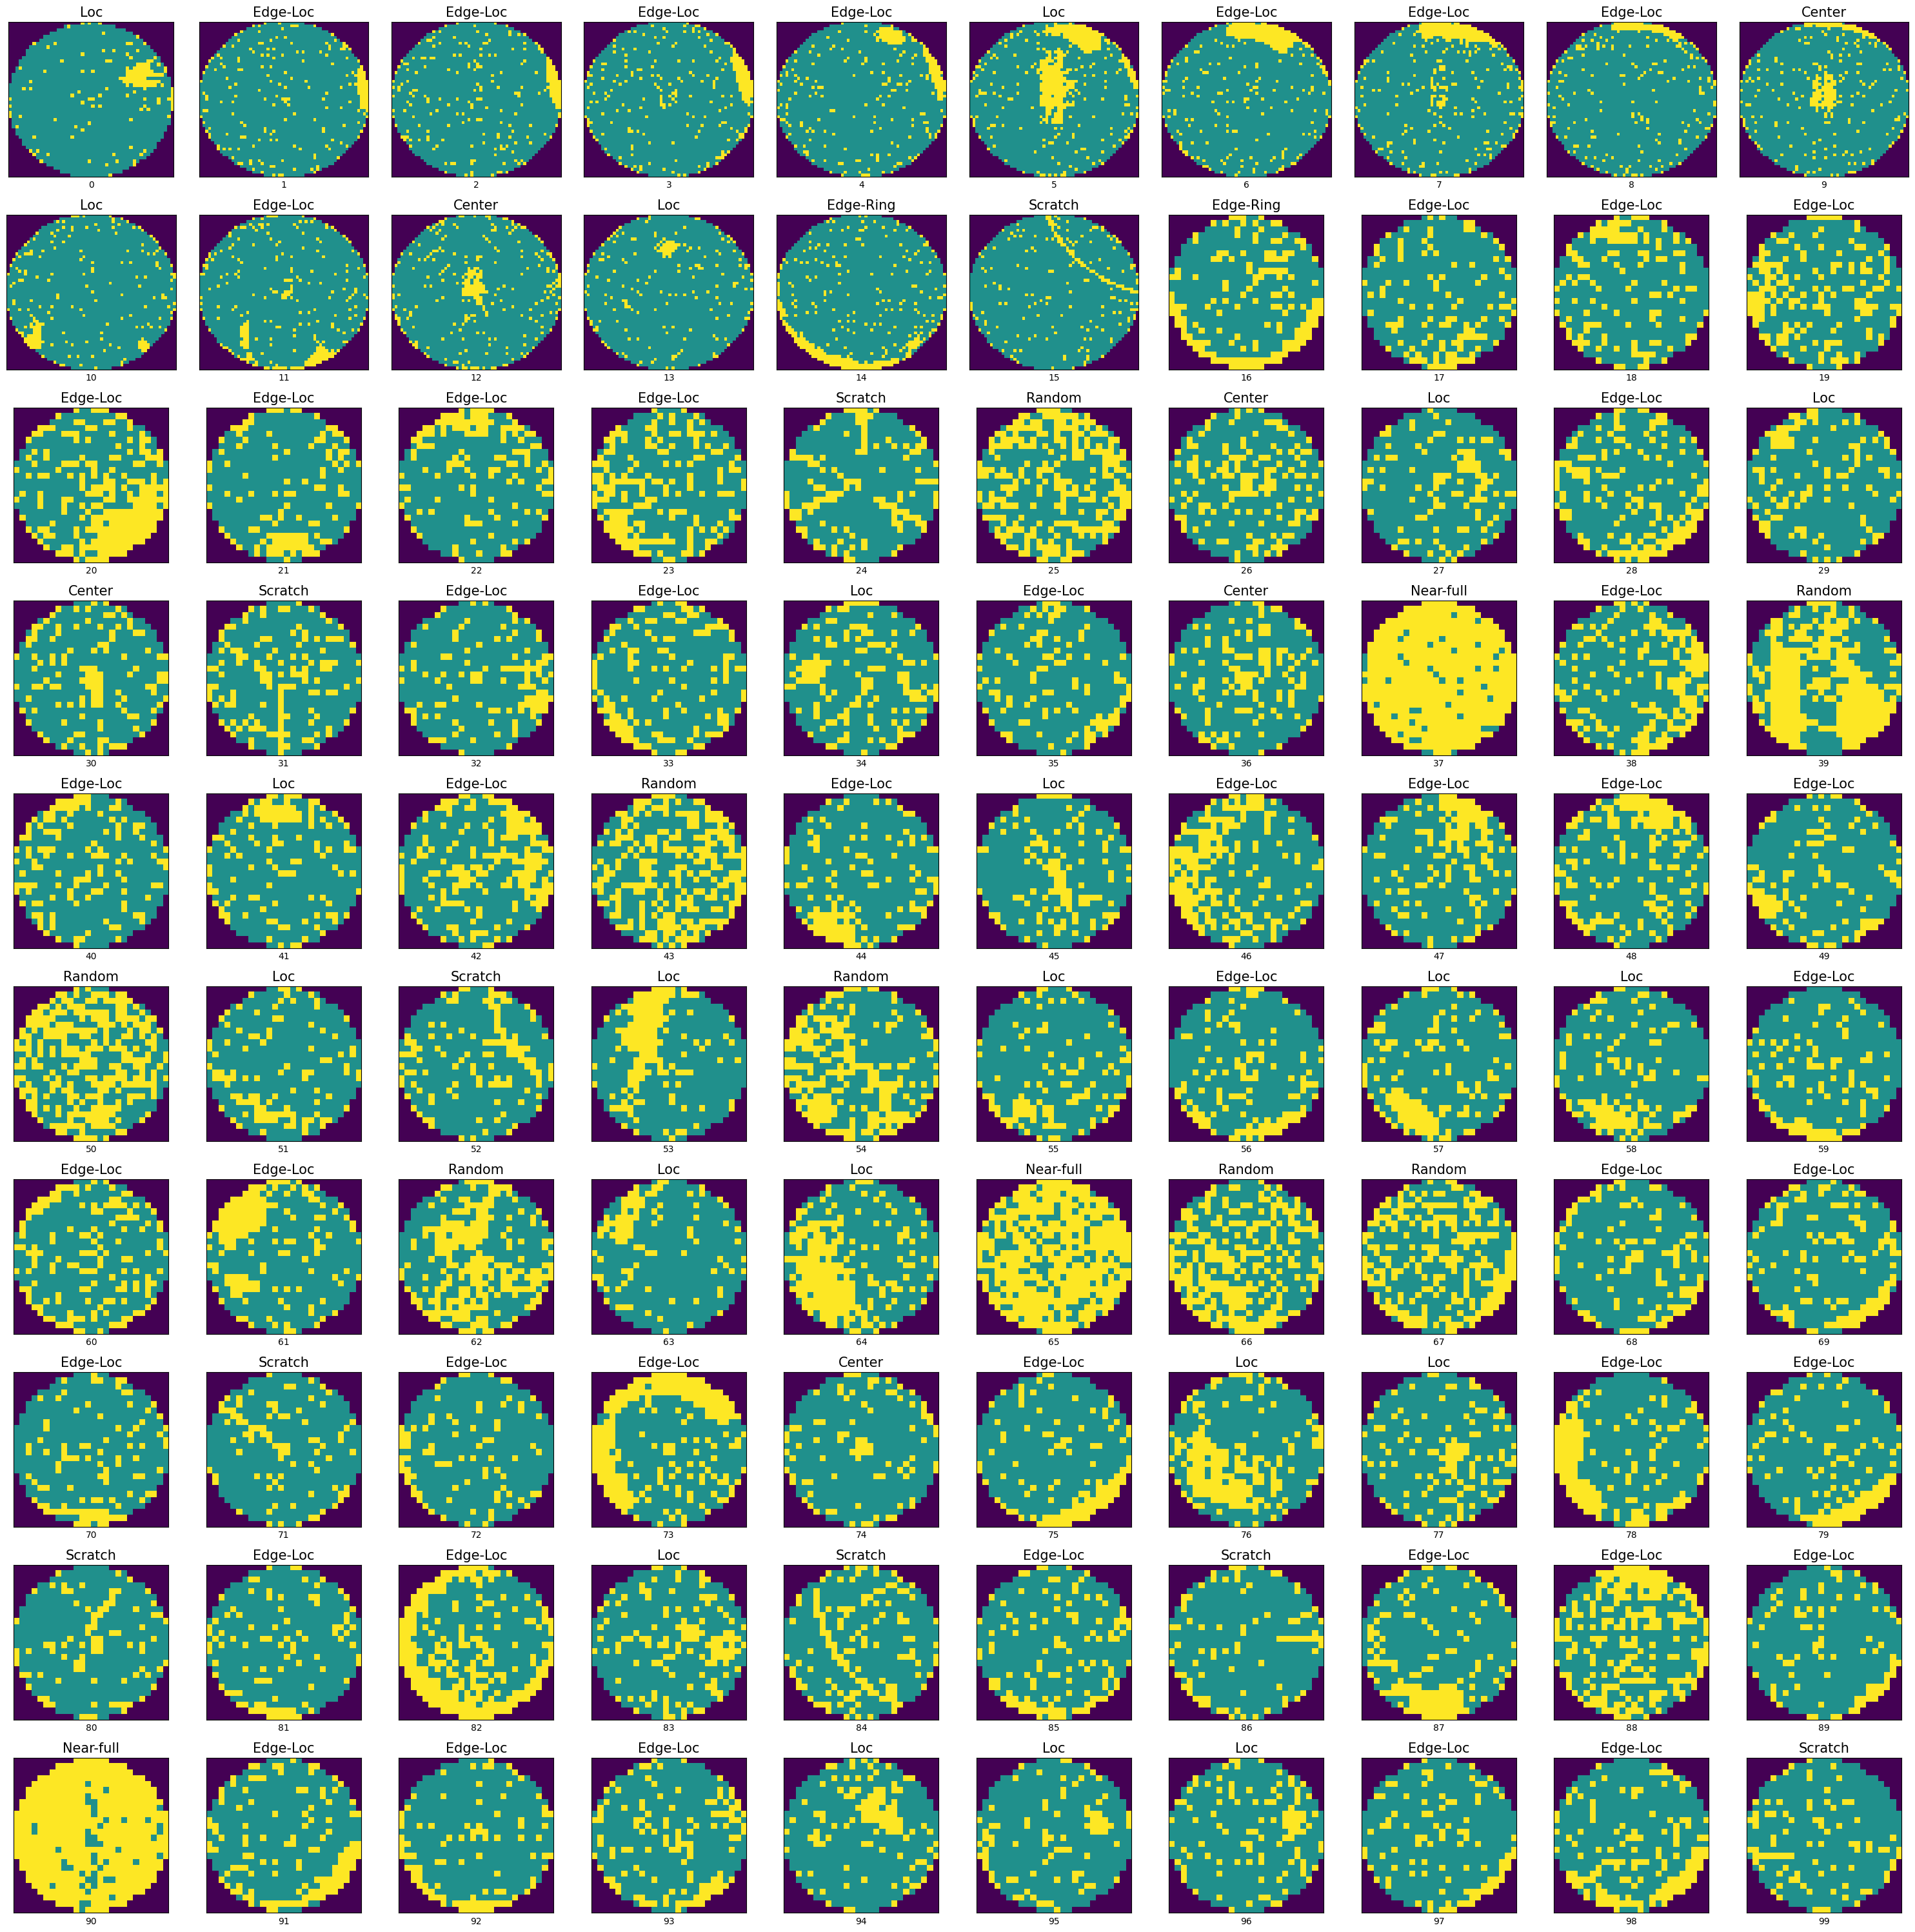

In [ ]:
# fig -> 전체 플롯(그림판)의 뼈대. 생성한 객체
# ax -> 100개의 subplot(개별 그림 영역)이 10×10 형태로 담긴 NumPy 배열
# nrows=10, ncols=10 -> subplot의 행, 열 수
# figsize=(30, 30) -> 전체 그림판의 크기 (인치 기준). 큼직하게 30×30 인치 설정
fig, ax = plt.subplots(nrows = 10, ncols = 10, figsize=(30, 30))

# ax -> 원래는 ax[행][열] 형식이지만, 이걸 1차원으로 펴서 ax[0] ~ ax[99]로 만들기
# ravel(order='C') -> C 스타일(행 우선)으로 펼침 → 왼쪽→오른쪽, 위→아래 순서
ax = ax.ravel(order='C')

# 0부터 99까지 반복 -> 총 100개의 subplot에 하나씩 이미지 배치
for i in range(100):
  # df_withpattern -> 결함 있는 웨이퍼들만 모은 데이터프레임 (생성된 객체)
  # waferMap 열 -> 각 웨이퍼의 2차원 이미지 정보가 들어있음 (NumPy 배열 형태)
  # [i] -> i번째 웨이퍼 이미지
  img = df_withpattern.waferMap[i] # 결함 있는 웨이퍼 맵 이미지 한 개를 불러옴
  ax[i].imshow(img) # i번째 subplot에 방금 가져온 이미지를 시각화

  # df_withpattern.failureType[i] -> 예: [['Center']] (리스트 안에 리스트가 한 번 더 있고 그 안에 문자열)
  # [0][0] -> 첫 번째 리스트 -> 다시 첫 번째 요소 -> "Center" (문자열을 꺼냄)
  # df_withpattern.failureType -> WM-811K 데이터셋 안에 원래부터 존재하는 열(column)
  ax[i].set_title(df_withpattern.failureType[i][0][0], fontsize=15)

  # 그림 아래에 그 웨이퍼의 인덱스 번호를 표시함
  ax[i].set_xlabel(df_withpattern.index[i], fontsize=10)

  # x축, y축 눈금 모두 제거
  ax[i].set_xticks([])
  ax[i].set_yticks([])

# 자동으로 간격 조정
plt.tight_layout()
plt.show()


- Log, Edge-Loc, Center, Near-full, Scratch, Random의 6가지로 나타난다

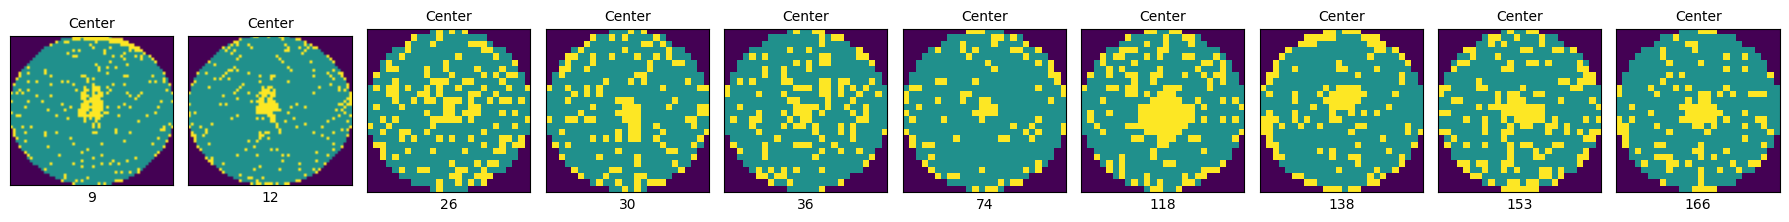

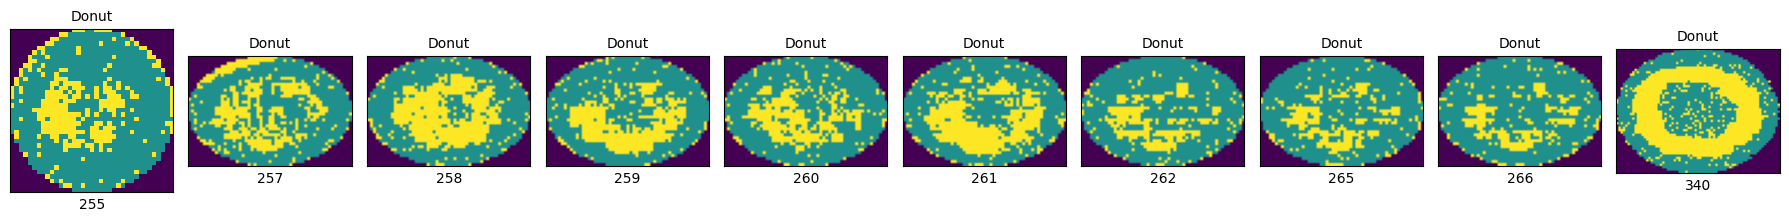

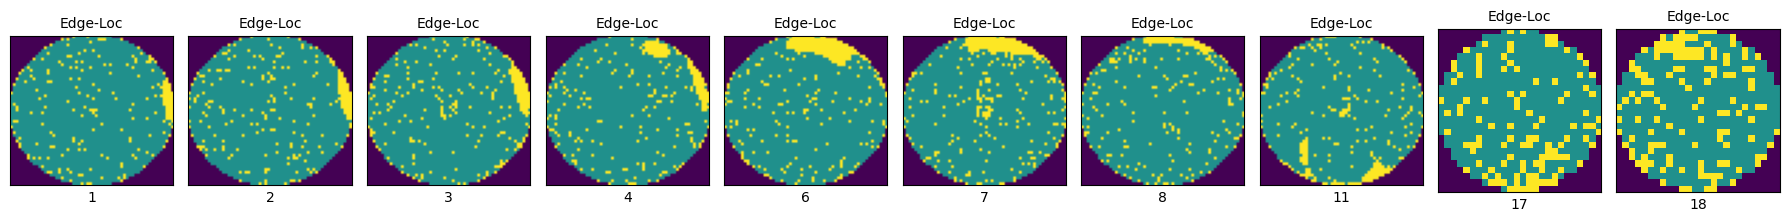

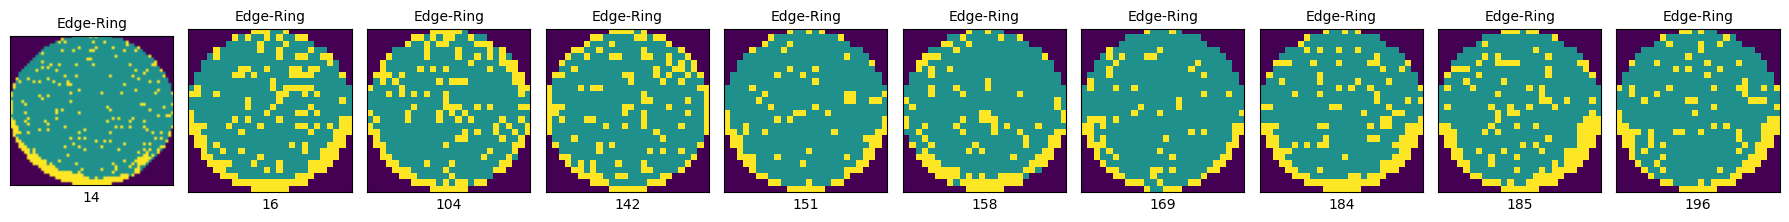

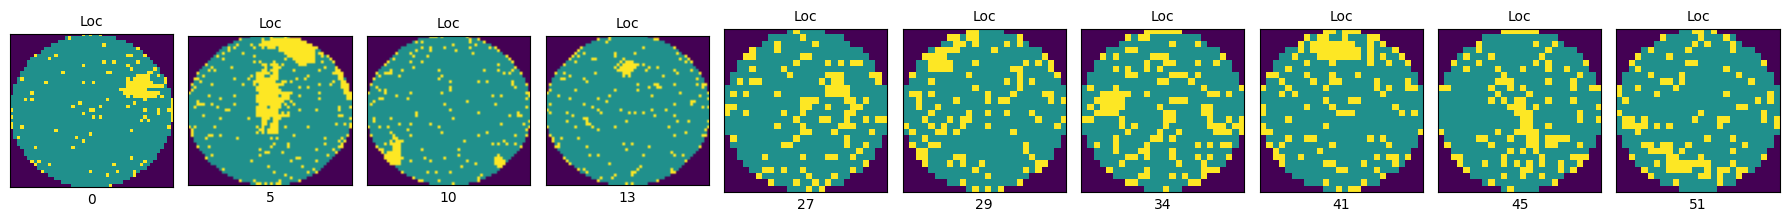

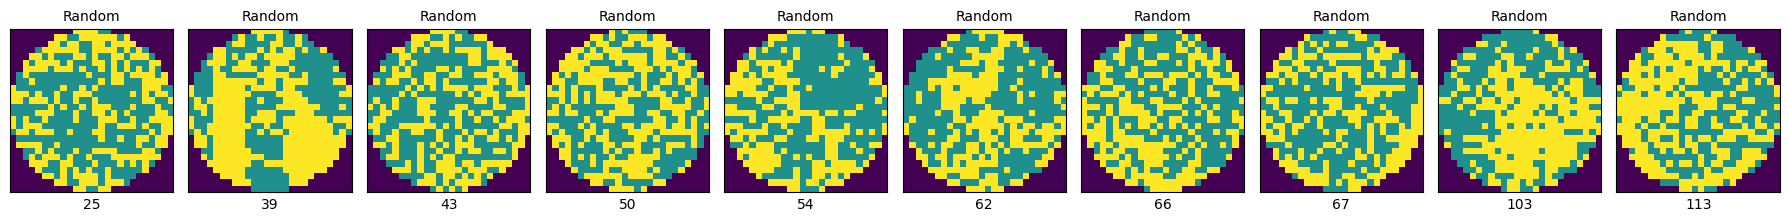

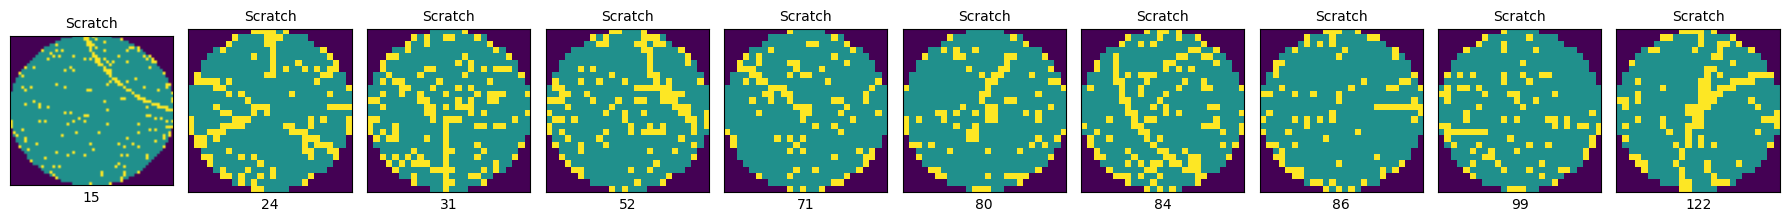

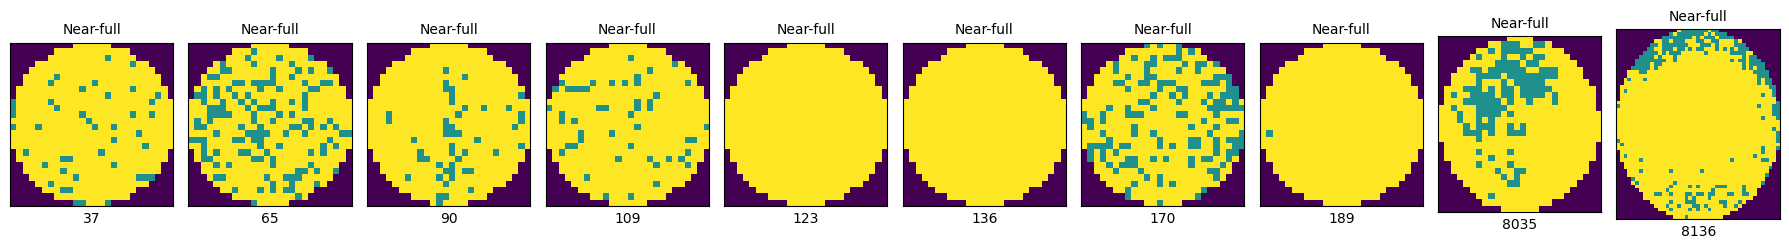

In [ ]:
x=[0,1,2,3,4,5,6,7] # 인덱스 8개
labels2=['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full'] # 라벨 8개

for i in x: # 즉, 라벨 8종류 각각에 대해

  # nrows × ncols -> subplot의 총 개수이며, k가 반복 가능한 최대 횟수
  # subplot = 10, k -> range(10)까지 가능함!, k -> range(11)부터 오류 발생!
  fig, ax=plt.subplots(nrows=1, ncols=10, figsize=(18,12))
  ax=ax.ravel(order='C') # ravel은 다차원 배열을 1차원으로 변경, C는 기본값

  # 중첩 for문 (여기선 1번만 도는 형태이며 j는 그냥 i와 같음)
  for j in [i]:  # 그냥 j = i
    # df_withpattern: 웨이퍼 불량 정보가 들어있는 DataFrame

    # failureType == labels2[j] -> 예시: labels2[0] = 'Center'이면 -> failureType이 'Center'인 행만 뽑음
    # df_withpattern.waferMap[...] -> 그 중에서 waferMap만 추출 (Series 형태)
    # img는 그 라벨에 속하는 waferMap 이미지들만 모은 상자 준비
    img=df_withpattern.waferMap[df_withpattern.failureType==labels2[j]]

    # 10개 웨이퍼맵 반복해서 시각화(img의 각 라벨마다 10개 waferMap 이미지 시각화)
    # 8개 라벨 × 각 라벨당 최대 10개 이미지 = 총 최대 80개 waferMap 이미지 시각화
    # ax는 [ax[0], ax[1], ..., ax[9]] -> 총 10개의 공간을 담은 배열
    # subplot이 10개 만들어졌기 때문에, 각각에 하나씩 그림을 그려주는 용도로 for문이 10번 도는 것
    for k in range(10):

      # 같은 라벨만 있는 img 상자에서 k번째(앞에 있는 0~9)를 꺼내서 ax[k]인 그림판에 넣고 시각화한다.

      # 라벨이 j인 waferMap들 중에서 k번째 이미지 데이터를 꺼내서, k번째 subplot(ax[k])에 시각화한다.
      # img[img.index[k]] -> 라벨 j에 해당하는 waferMap 데이터 중 k번째 그림
      # ax[k].imshow(...) -> k번째 subplot 창에 그림 표시
      ax[k].imshow(img[img.index[k]])
      ax[k].set_title(df_withpattern.failureType[img.index[k]][0][0], fontsize=10) # 타이틀
      ax[k].set_xlabel(df_withpattern.index[img.index[k]], fontsize=10) # x축에 인덱스 표시

      # 눈금 제거
      ax[k].set_xticks([])
      ax[k].set_yticks([])
    plt.tight_layout() # 자동 간격 조정
    plt.show() # 시각화

# 먼저 x의 각각 인덱스를 라벨(i) 하나에 subplot 10개를 준비했으니,
# 그걸 채우기 위한 반복자(k)는 당연히 range(10)이.


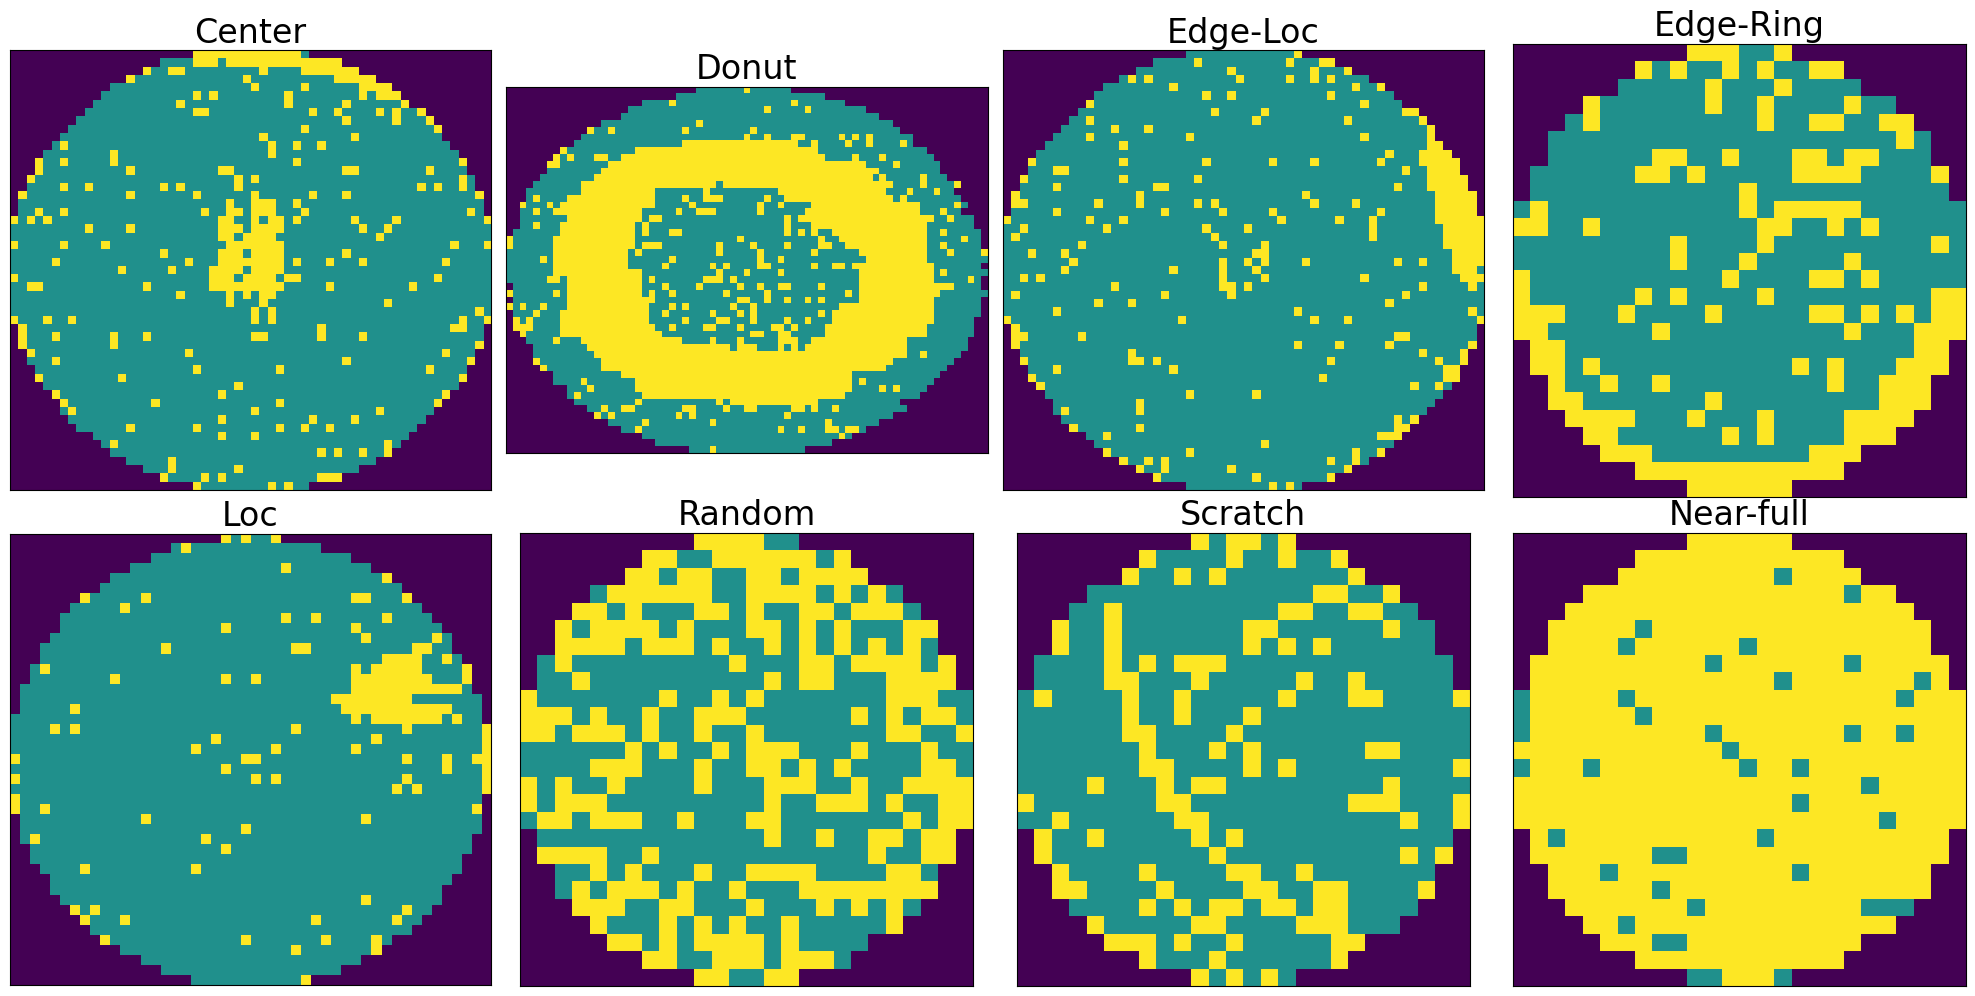

In [ ]:
x=[9, 340, 3, 16, 0, 25, 84, 37]
labels2=['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

fig,ax=plt.subplots(nrows=2, ncols=4, figsize=(20,10))

# ravel 함수 -> 1차원으로 평평하게 만들어주는 함수
# order='C' ->  C 언어 스타일: 행(row) 기준 정렬(순서: 왼 -> 오)
# 2행 4열(2, 4)를 (8,)로 만든다는 것.(행 단위로 가로로 쭉 펼쳐서 1차원 배열로 만듬)
ax=ax.ravel(order='C')
for i in range(8):
    img=df_withpattern.waferMap[x[i]]
    ax[i].imshow(img)
    ax[i].set_title(df_withpattern.failureType[x[i]][0][0], fontsize=24)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show()

# 그림판에 2행 4열 크기를 정하고 이 후 불량 이미지 x를 img로 각각 담은 후
# ax라는 그림판에 넣은 후 시각화


이제 데이터를 변형해보자.
- Data transformation : 머신러닝 하기 위해 데이터를 전처리 하는 과정이 필요할거같다.

In [ ]:
# 이미지 필터링, 윤곽 추출, 특징 추출 등 이미지 분석 및 전처리를 할 수 있는 도구들을 모아놓은 "상자"
import skimage

# #  이미지에서 객체의 크기, 모양, 경계선 같은 걸 측정
from skimage import measure

# 라돈 변환을 하기 위한 함수
from skimage.transform import radon

# 이미지에서 직선(선분)을 찾아내는 알고리즘입니다. (확률적 허프 변환)
from skimage.transform import probabilistic_hough_line

# 보간법(interpolation) – 데이터 포인트 사이에 값을 매끄럽게 이어주는 데 사용
from scipy import interpolate

# 평균, 분산, 회귀, 정규성 검정 등 통계 관련 기능을 제공
from scipy import stats


- wafermap을 13개로 분할하고 defect(결함)의 밀도를 계산해보자.
- failure pattern에 따라서 밀도의 분포는 다 다를거다. (Center type은 중앙쪽 밀도가 높을것이니까.)

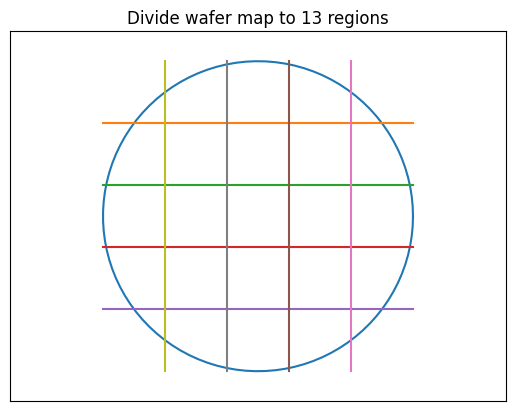

In [ ]:
# 0에서 2π(약 6.28)까지 100개의 숫자를 균등하게 배열로 만들어주는 코드
# np.linspace(start, stop, num) -> start부터 stop까지 num개의 숫자를 균등하게 분포시켜 생성.
an=np.linspace(0, 2*np.pi, 100)

# 위에서 만든 각도 배열 an을 사용해서 반지름 2.5짜리 원을 그리는 코드
# np.cos, np.sin: 각각 배열에 대해 요소별로 코사인/사인 값 계산.
# plt.plot(x, y): 좌표들을 연결한 선 그래프를 그림.
plt.plot(2.5*np.cos(an), 2.5*np.sin(an))

# x축과 y축의 단위 길이를 같게 만들어주기
# axis('equal')을 사용하면 원은 진짜 원처럼 보이게 됨.
plt.axis('equal')

# x축과 y축의 보이는 범위를 직접 설정
# plt.axis([xmin, xmax, ymin, ymax])
plt.axis([-4,4,-4,4])

# 가로 방향의 선(수평선)을 4개 그리기
# x축 방향: -2.5부터 2.5까지
# y축은 고정값: 1.5, 0.5, -0.5, -1.5 (총 3개의 구간을 나눔)
plt.plot([-2.5, 2.5], [1.5, 1.5])
plt.plot([-2.5, 2.5], [0.5, 0.5 ])
plt.plot([-2.5, 2.5], [-0.5, -0.5 ])
plt.plot([-2.5, 2.5], [-1.5,-1.5 ])

# 세로 방향의 선(수직선)을 4개 그리기
# x축은 고정값: 0.5, 1.5, -0.5, -1.5 (총 3개의 구간을 나눔)
# y축 방향: -2.5부터 2.5까지
plt.plot([0.5, 0.5], [-2.5, 2.5])
plt.plot([1.5, 1.5], [-2.5, 2.5])
plt.plot([-0.5, -0.5], [-2.5, 2.5])
plt.plot([-1.5, -1.5], [-2.5, 2.5])

plt.title("Divide wafer map to 13 regions")
plt.xticks([]) # 축 없애기
plt.yticks([])
plt.show()

# WARNING:matplotlib.axes._base:Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.

# plt.axis('equal')       -> x축과 y축의 '비율'을 1:1로 고정해!
# plt.axis([-4,4,-4,4])   -> x축과 y축의 '범위'를 -4~4로 고정해!
# matplotlib 입장에서 "비율도 지키고, 범위도 지켜야 해!" -> 서로 충돌
# 이럴 때 matplotlib은 축 비율을 우선으로 하고, y축 범위는 무시하면서 이 경고를 띄운다.

# 단순한 경고일 뿐, 이미지가 찌그러지지 않도록 비율을 우선한 것이라 문제가 되지 않는다.

# plt.axis() 대신 ax.set_...()를 쓰면 경고 없이 더 세밀한 제어가 가능


In [ ]:
# Wafer map을 13개 영역으로 나눈 다음, 각 영역마다 결함의 밀도(density)를 계산해서 리스트로 반환하는 함수


# 하나의 영역(x)에 대해 결함 밀도를 %로 계산
# np.sum(x==2) -> 값이 2인 개수
# np.size(x) -> 전체 픽셀 수 (행 × 열)
# 전체 비율: sum / size × 100 -> 퍼센트 %
def cal_den(x):
  return 100*(np.sum(x==2)/np.size(x))

# 입력된 wafer map (x)을 13개 영역으로 나눈 뒤, 각각의 영역에 대해 cal_den()을 적용해서 리스트 형태로 반환

def find_regions(x):
  rows=np.size(x,axis=0) # rows: 행 수 (높이) -> np.size(x, axis=0) = x.shape[0]
  cols=np.size(x,axis=1) # cols: 열 수 (너비) -> np.size(x, axis=1) = x.shape[1]

  # 행과 열을 5등분하기 위한 기준점 리스트 (rows//5, cols//5는 5등분 간격)
  # 예를 들어 rows = 50이면: ind1 = [0, 10, 20, 30, 40], cols = 50이면: ind2 = [0, 10, 20, 30, 40]
  # 행 방향으로는
  # 0~10
  # 10~20
  # 20~30
  # 30~40
  # 40~끝 -> 이런 식으로 5등분 경계
  ind1=np.arange(0,rows,rows//5)
  ind2=np.arange(0,cols,cols//5)

  # 가장자리 영역

  # ind1 = np.arange(0, 50, 50//5) -> [0, 10, 20, 30, 40]
  # ind1[0] = 0, ind1[1] = 10 -> x[0:10, :] -> 0행부터 9행까지, 전체 열을 가져옴
  # : 하나만 쓰면 "전부 다"라는 뜻
  reg1=x[ind1[0]:ind1[1],:] # 위쪽 행만 모든 열 가져옴
  reg3=x[ind1[4]:,:] # 아래쪽 행만 모든 열 가져옴
  reg4=x[:,ind2[0]:ind2[1]] # 모든 행, 왼쪽 열만 가져옴
  reg2=x[:,ind2[4]:] # 모든 행, 오른쪽 열만 가져옴

  # 중앙 3x3 격자
  reg5=x[ind1[1]:ind1[2],ind2[1]:ind2[2]]
  reg6=x[ind1[1]:ind1[2],ind2[2]:ind2[3]]
  reg7=x[ind1[1]:ind1[2],ind2[3]:ind2[4]]
  reg8=x[ind1[2]:ind1[3],ind2[1]:ind2[2]]
  reg9=x[ind1[2]:ind1[3],ind2[2]:ind2[3]]
  reg10=x[ind1[2]:ind1[3],ind2[3]:ind2[4]]
  reg11=x[ind1[3]:ind1[4],ind2[1]:ind2[2]]
  reg12=x[ind1[3]:ind1[4],ind2[2]:ind2[3]]
  reg13=x[ind1[3]:ind1[4],ind2[3]:ind2[4]]

  fea_reg_den = []

  # 전체 wafer map (x), 슬라이싱 -> 13개 영역 (reg1 ~ reg13), 각 영역 분석
  # cal_den(regX)로 결함률(%), 리스트에 담음 -> fea_reg_den = [%, %, ..., %]

  # reg1~13은 숫자 하나가 아니라 "2차원 배열"
  # 먼저 reg1~13이란 배열이 각각 존재한 상태에서 cal_den(reg1~13)을 사용하면
  # 각각의 reg1~13에서 값이 2인 것이 몇 개인지 계산해서 퍼센트(%)로 반환함.
  # 그 값을 fea_reg_den 리스트에 담는다.
  fea_reg_den = [cal_den(reg1),cal_den(reg2),cal_den(reg3),cal_den(reg4),cal_den(reg5),cal_den(reg6),cal_den(reg7),cal_den(reg8),cal_den(reg9),cal_den(reg10),cal_den(reg11),cal_den(reg12),cal_den(reg13)]
  return fea_reg_den


In [ ]:
# df_withpattern -> wafer map 데이터가 들어 있는 데이터프레임
# df_withpattern.waferMap -> wafer map이 담긴 시리즈(Series) – 각각이 2차원 배열
# .apply(find_regions) -> 각 wafer map에 find_regions() 함수를 한 개씩 적용
# df_withpattern['fea_reg'] = ... -> 그 결과를 새로운 열 'fea_reg'로 저장
# fea_reg 열에 13개짜리 결함률 벡터 리스트가 들어감
df_withpattern['fea_reg']=df_withpattern.waferMap.apply(find_regions)


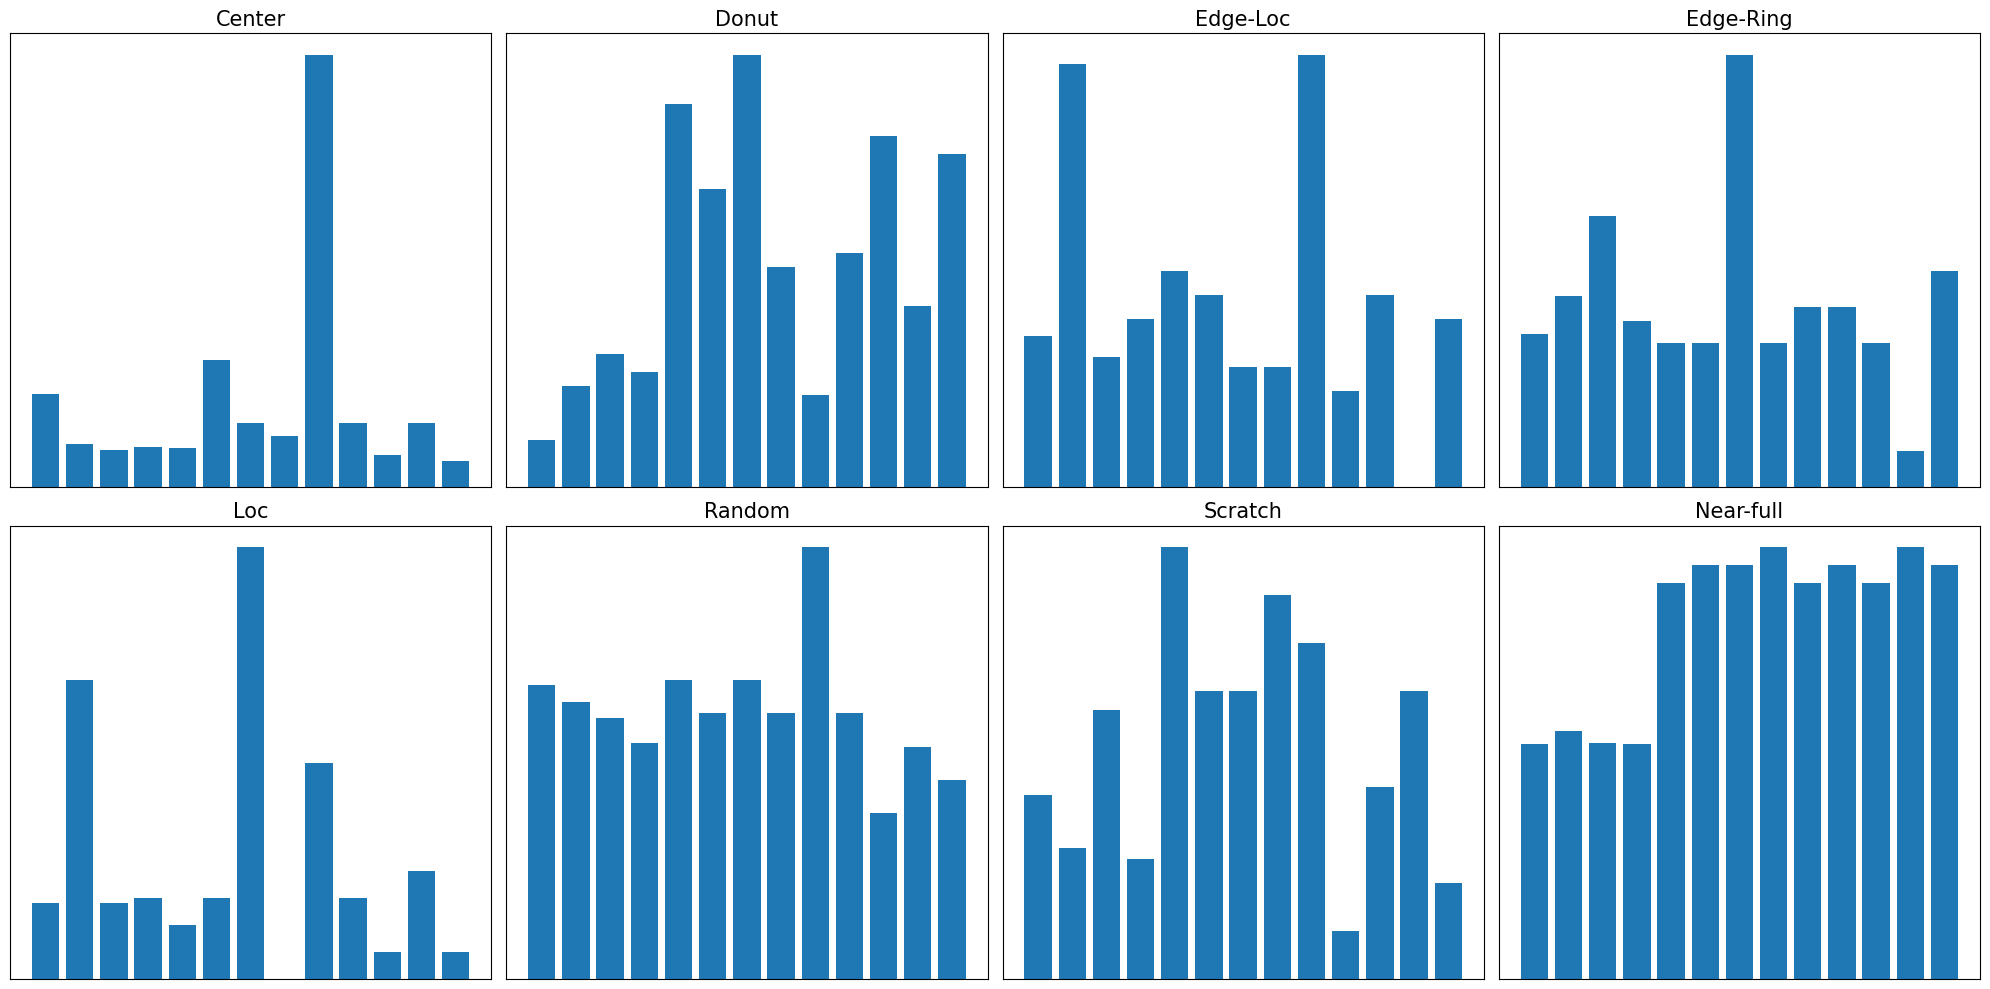

In [ ]:
x = [9,340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

fig, ax = plt.subplots(nrows = 2, ncols = 4,figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):

  # np.linspace(1,13,13) -> 1부터 13까지 균등하게 13개 숫자를 생성 (x축용)
  # df_withpattern.fea_reg[x[i]]: df_withpattern 데이터프레임에서 x[i]번째 샘플의 fea_reg 값을 가져옴.
  ax[i].bar(np.linspace(1,13,13),df_withpattern.fea_reg[x[i]])

  # df_withpattern.failureType[x[i]]: 해당 샘플의 결함 타입
  # [0][0]: 이중 리스트 안 문자열 꺼내기 위해 2번 인덱싱
  ax[i].set_title(df_withpattern.failureType[x[i]][0][0],fontsize=15)

  # # x축과 y축 눈금을 제거
  ax[i].set_xticks([])
  ax[i].set_yticks([])

# 자동으로 레이아웃 정렬 (그래프 간격 조정)
plt.tight_layout()
plt.show()

# 막대그래프에서 막대가 길수록 -> 그 영역에 결함이 많다는 뜻


- failure type의 밀도를 표현한 그래프
- 밀도기반 그래프가 더 분류하기 쉽게 만들 수 있기 때문

- 라돈 변환을 기반으로 투영된 wafer map을 2d로 표현가능하다.

In [ ]:
def change_val(img):
    img[img==1] =0 # 조건에 해당하는 위치(==1)의 값을 0으로 바꾼다
    return img # 값이 바뀐 이미지 결과를 리턴

# 원본 데이터를 건드리지 않고, 새로운 열(new_waferMap)을 만들기 위해 복사
# df_withpattern이라는 원본 데이터프레임을 복사해서 df_withpattern_copy 객체 생성
df_withpattern_copy = df_withpattern.copy()

# wafer map 하나하나에 대해 그 안에 있는 1을 전부 0으로 바꾸고 바뀐 이미지를 새로운 열 new_waferMap에 넣는 것
# 이것들의 이름을 new_waferMap이라 하며 df_withpattern_copy 안에 존재
df_withpattern_copy['new_waferMap'] =df_withpattern_copy.waferMap.apply(change_val)


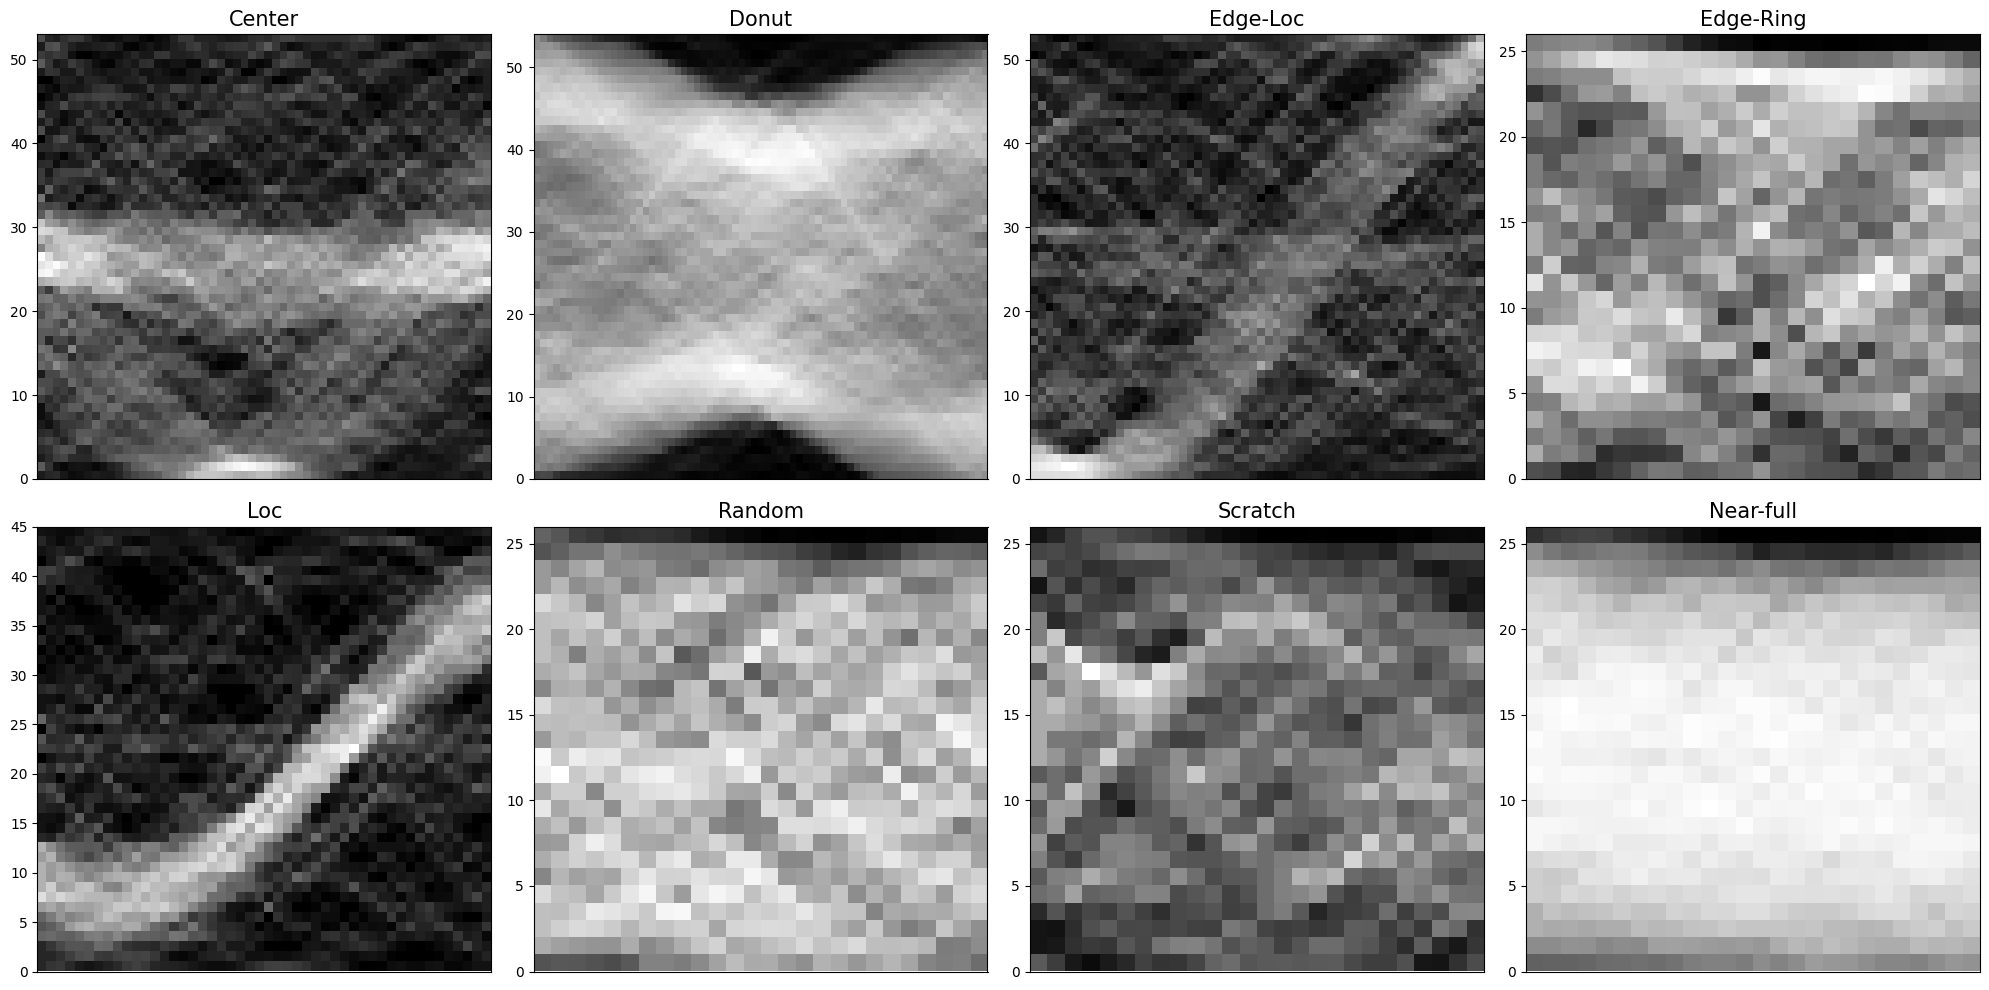

In [ ]:
x = [9,340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
  img = df_withpattern_copy.waferMap[x[i]]

  # 라돈 변환을 위한 투사 각도(theta) 를 생성
  # 0도부터 180도까지, img.shape 중 큰 값만큼 나눠서 각도 리스트를 생성
  # (예: 이미지 크기가 20x25면 theta = np.linspace(0.,180.,25) 이런 식)

  # endpoint=False -> 마지막 값 포함하지 않음
  # (0부터 10까지를 5개로 균등하게 나눔 -> [0. , 2. , 4. , 6. , 8. ] <- 10은 없음.)

  # np.linspace(a, b, n) → a부터 b까지를 n개로 나누는 evenly spaced 배열(균등 간격으로 나눠진 배열)
  theta = np.linspace(0., 180., max(img.shape), endpoint=False)

  # img를 라돈 변환하여 sinogram을 생성함
  # 라돈 변환: CT 촬영처럼 다양한 각도에서 투영(projection)된 이미지 합성본을 만드는 것
  sinogram = radon(img, theta=theta)

  # ax[i].imshow(...): i번째 subplot에 이미지를 그림
  # sinogram: 라돈 변환된 이미지
  # cmap=plt.cm.Greys_r: 회색조(reverse) 색상 맵 사용 -> 검은색이 높은 값, 흰색이 낮은 값처럼 표현됨
  # extent=(0, 180, 0, sinogram.shape[0]): x축은 0~180도, y축은 sinogram 높이까지로 좌표 범위 설정
  # aspect='auto': 비율 자동 조정
  ax[i].imshow(sinogram, cmap=plt.cm.Greys_r, extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')
  ax[i].set_title(df_withpattern_copy.failureType[x[i]][0][0],fontsize=15)
  ax[i].set_xticks([]) # x축 눈금 제거
plt.tight_layout() # 그래프 간 간격 자동 조정

plt.show()

# 투영값이 크다는 건, 어떤 각도에서 강하게 감지된 구조물이 있다는 뜻
# 그게 wafer의 구조와 무관한 불규칙한 패턴이면 -> 결함일 가능성이 매우 높아
# sinogram에서 진한 흰 곡선이나 선이 눈에 띄면, 그건 결함일 확률이 높다.

# 완벽하게 균일한 wafer는 현실적으로 거의 없음
# (생산 공정 중 약간의 미세한 흔들림, 먼지, 불균형 -> 약한 신호(=희미한 하얀 선)로 나타남)

# 희미한 하얀 선 -> 정상적이거나 무시해도 될 정도의 구조(패턴, 모서리, 배경의 잔미세 구조일 수 있음)

# 진한 하얀 선이나 곡선 -> 투영값이 확 튐
# (이건 무언가 덩어리, 줄, 크랙, 얼룩이 일정 각도에서 강하게 튀어나온다는 의미이기에 결함 가능성이 높음)


- 각 failure type의 라돈 변환 결과이다.

- 하지만 웨이퍼 크기가 다 달라서 특정지어 단정하기가 어렵다.
따라서 cubic interpolation (큐빅 보간법: 3차 함수(곡선)를 이용한 보간 방식)을 활용하여 라돈 변환에서의 각 행 평균과 표준편차에 대한 고정된 값을 얻을 것이다.
그리고 그 값은 각각 20으로 고정한다.

- 결과적으로 dimension은 40이 된다.

- 보간법 : 중간 값을 모를 때, 주변 값들을 기준으로 그 사이 값을 예측하는 방법

In [ ]:
def cubic_inter_mean(img):
  # np.linspace: 균등 분할된 배열 생성
  # max(img.shape): img의 모양 중 더 큰 축을 가져옴
  theta = np.linspace(0., 180., max(img.shape), endpoint=False)
  sinogram = radon(img, theta=theta)

  # axis=1: 행 방향 평균 -> 각 행마다의 평균을 구함(가로줄 방향 평균)
  xMean_Row = np.mean(sinogram, axis = 1)

  # xMean_Row.size: 전체 원소 개수
  # xMean_Row.size: 끝 값까지 포함하면서 전체 개수만큼 분할
  x = np.linspace(1, xMean_Row.size, xMean_Row.size)
  y = xMean_Row

  # interpolate: scipy.interpolate 모듈 (보간 기능 제공)
  # interp1d: 1차원 보간 함수 생성
  # x, y: 입력값과 출력값 (좌표쌍 개념)
  # kind='cubic': 3차 함수 방식으로 부드럽게 연결
  # 어떤 x값이 오면 그에 맞는 y값을 계산해주는 f 객체
  f = interpolate.interp1d(x, y, kind = 'cubic')

  # 20: 20개의 점을 균등하게 나눔 -> 결과적으로 원래보다 작아진 x좌표값 집합
  # (목적: 전체 평균값에서 20개의 포인트만 보간된 값으로 요약)
  xnew = np.linspace(1, xMean_Row.size, 20)

  # use interpolation function returned by `interp1d`
  # (interp1d에서 반환된 보간 함수를 사용한다.)
  ynew = f(xnew)/100
  return ynew # 20개의 평균값 배열 반환

def cubic_inter_std(img):
  theta = np.linspace(0., 180., max(img.shape), endpoint=False)
  sinogram = radon(img, theta=theta)

  # np.std: 표준편차 계산 함수 (결과: 각 위치에 대해 투영값들의 흩어짐 정도 (분산의 루트))
  xStd_Row = np.std(sinogram, axis=1)
  x = np.linspace(1, xStd_Row.size, xStd_Row.size)
  y = xStd_Row
  f = interpolate.interp1d(x, y, kind = 'cubic')
  xnew = np.linspace(1, xStd_Row.size, 20) # 20개 보간
  ynew = f(xnew)/100   # use interpolation function returned by `interp1d`
  return ynew # 20개짜리 벡터 반환


In [ ]:
# pandas DataFrame에서 열 추가하는 방식
# cubic_inter_mean, cubic_inter_std를 이미지(waferMap)에 적용해서 새로운 열을 만드는 코드

# 이 두 줄이 바로 라돈 기반 특징 40개를 만드는 코드
df_withpattern_copy['fea_cub_mean'] =df_withpattern_copy.waferMap.apply(cubic_inter_mean)
df_withpattern_copy['fea_cub_std'] =df_withpattern_copy.waferMap.apply(cubic_inter_std)


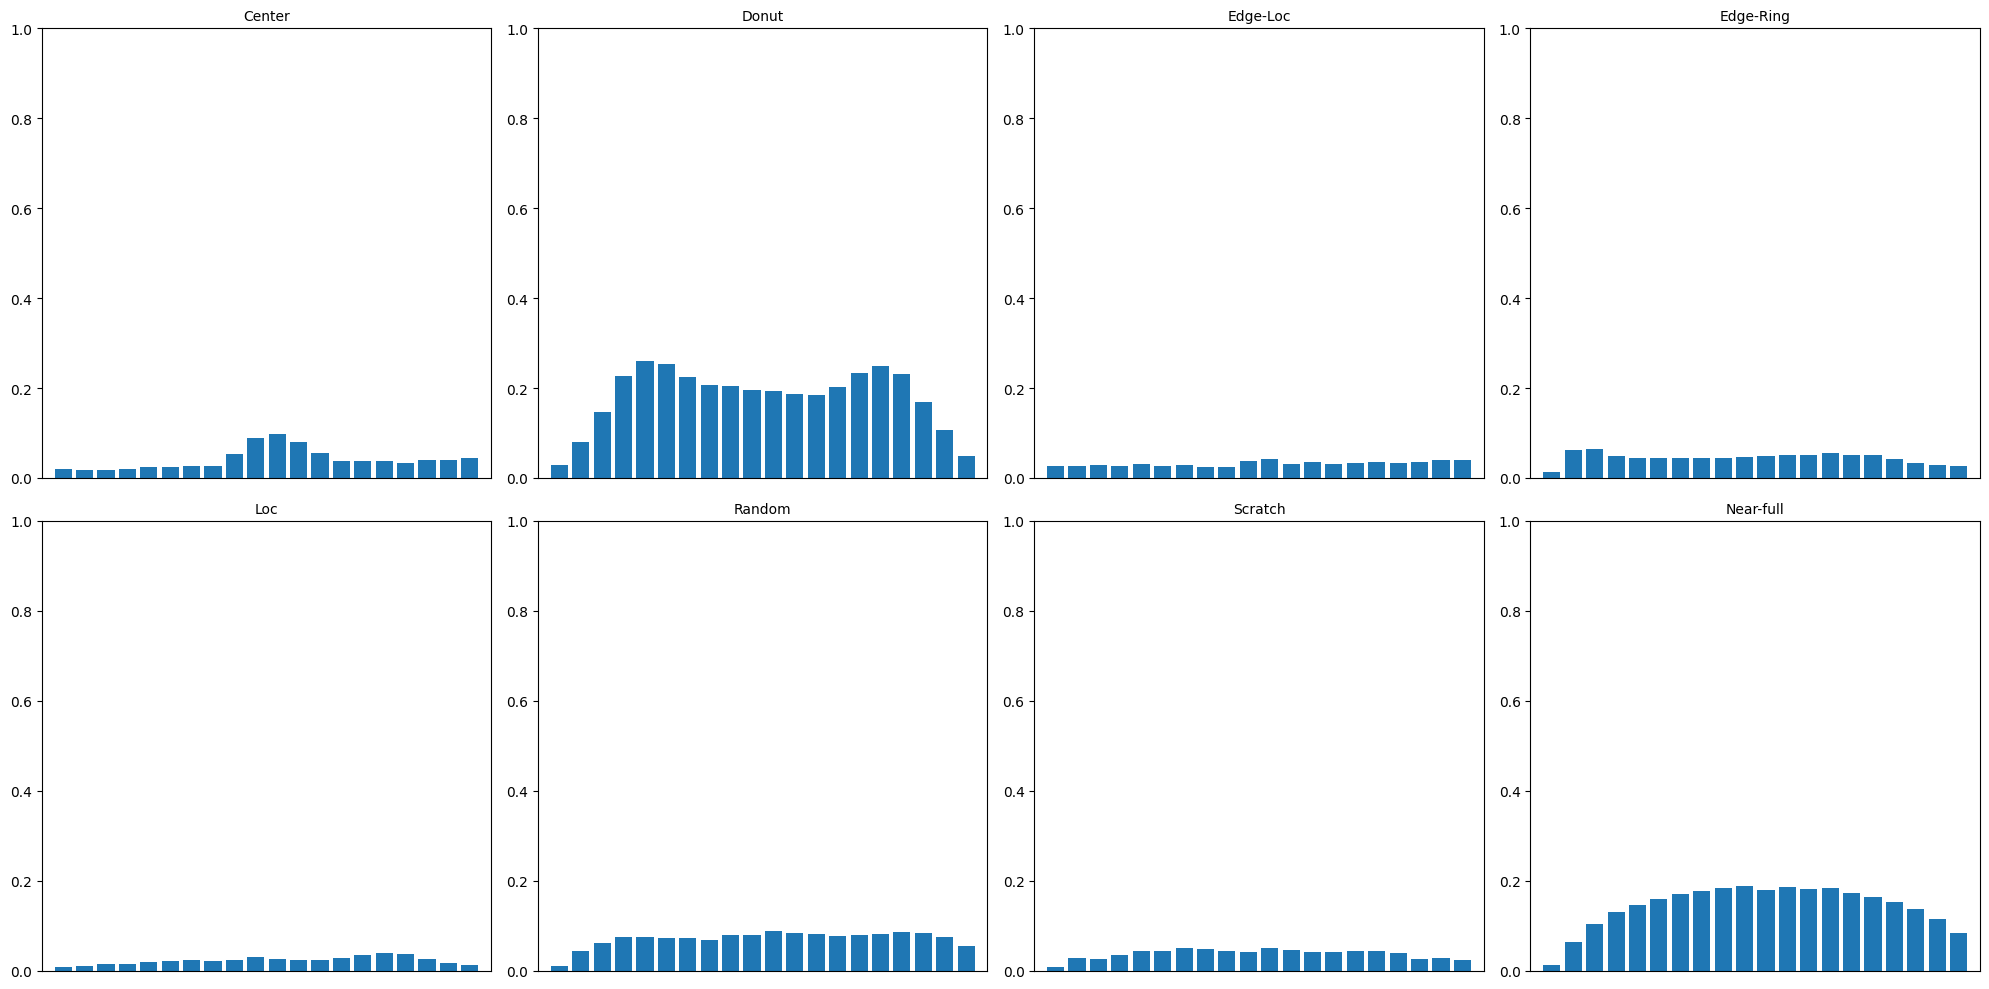

In [ ]:
x = [9,340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

fig, ax = plt.subplots(nrows = 2, ncols = 4,figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    ax[i].bar(np.linspace(1,20,20),df_withpattern_copy.fea_cub_mean[x[i]])
    ax[i].set_title(df_withpattern_copy.failureType[x[i]][0][0],fontsize=10)
    ax[i].set_xticks([])
    ax[i].set_xlim([0,21]) # x축 범위를 0~21로 고정(여유를 두기 위함)
    ax[i].set_ylim([0,1]) # y축 범위를 0~1로 고정
plt.tight_layout()
plt.show()

# ynew = f(xnew) / 100 -> 보간된 평균값이 너무 클 수 있어서 0~1로 정규화하기 위해
# 보간된 값들이 너무 크거나 범위가 들쑥날쑥하면, 나중에 모델 학습할 때 영향을 크게 줄 수 있기 때문


# 시각화를 할 경우에는 /100을 빼고 보는게 좋기에 /100을 뺐음
# 다만 학습할 땐 /100을 해야 한다.

# WM-811k Wafermap 코드의 결과와 실제와 좀 다르게 시각화 됨.
# (형태는 비슷하나 실습으로 하여 나타난 시각화 막대 그래프가 좀 더 부드러움.)

# 막대가 요란하게 튄다는 건 일부 값이 과하게 크다는 뜻 -> 때론 센서 노이즈, 결함 이상치(outlier)일 수 있다.
# 막대가 적당히 부드럽게 나왔다는 건 -> 라돈 결과가 안정적이고 보간(interpolate) 결과도 균형 있음을 의미

# 학습 모델 입장에서는 안정적인게 더 유리함
# 막대가 너무 튀면 모델은 그 튄 값을 특이한 패턴으로 학습 -> 잘못하면 오버피팅
# 부드러운 특징 벡터 -> 범용적인 특징 추출로 이어지고 새로운 웨이퍼도 더 잘 분류할 수 있음.

# 범용적인 특징 추출:
# 특정 데이터에만 의존하지 않고, 다양한 상황에서도 잘 작동할 수 있는 특징을 뽑아낸다는 뜻


- 가장 두드러진 영역을 식별하는 것은 결국 노이즈를 필터링 하는 것과 같다.

- 따라서, 우리는 가장 두드러지는 부분의 최대 영역을 고르고 region labeling(지역 라벨링) 알고리즘을 사용할 것이다.

- 이러한 두드러지는 영역에서 면적, 둘레, 장축길이, 단축길이, 견고함, 이심률 등등의 기하학적 특성을 뽑아내볼 것이다.

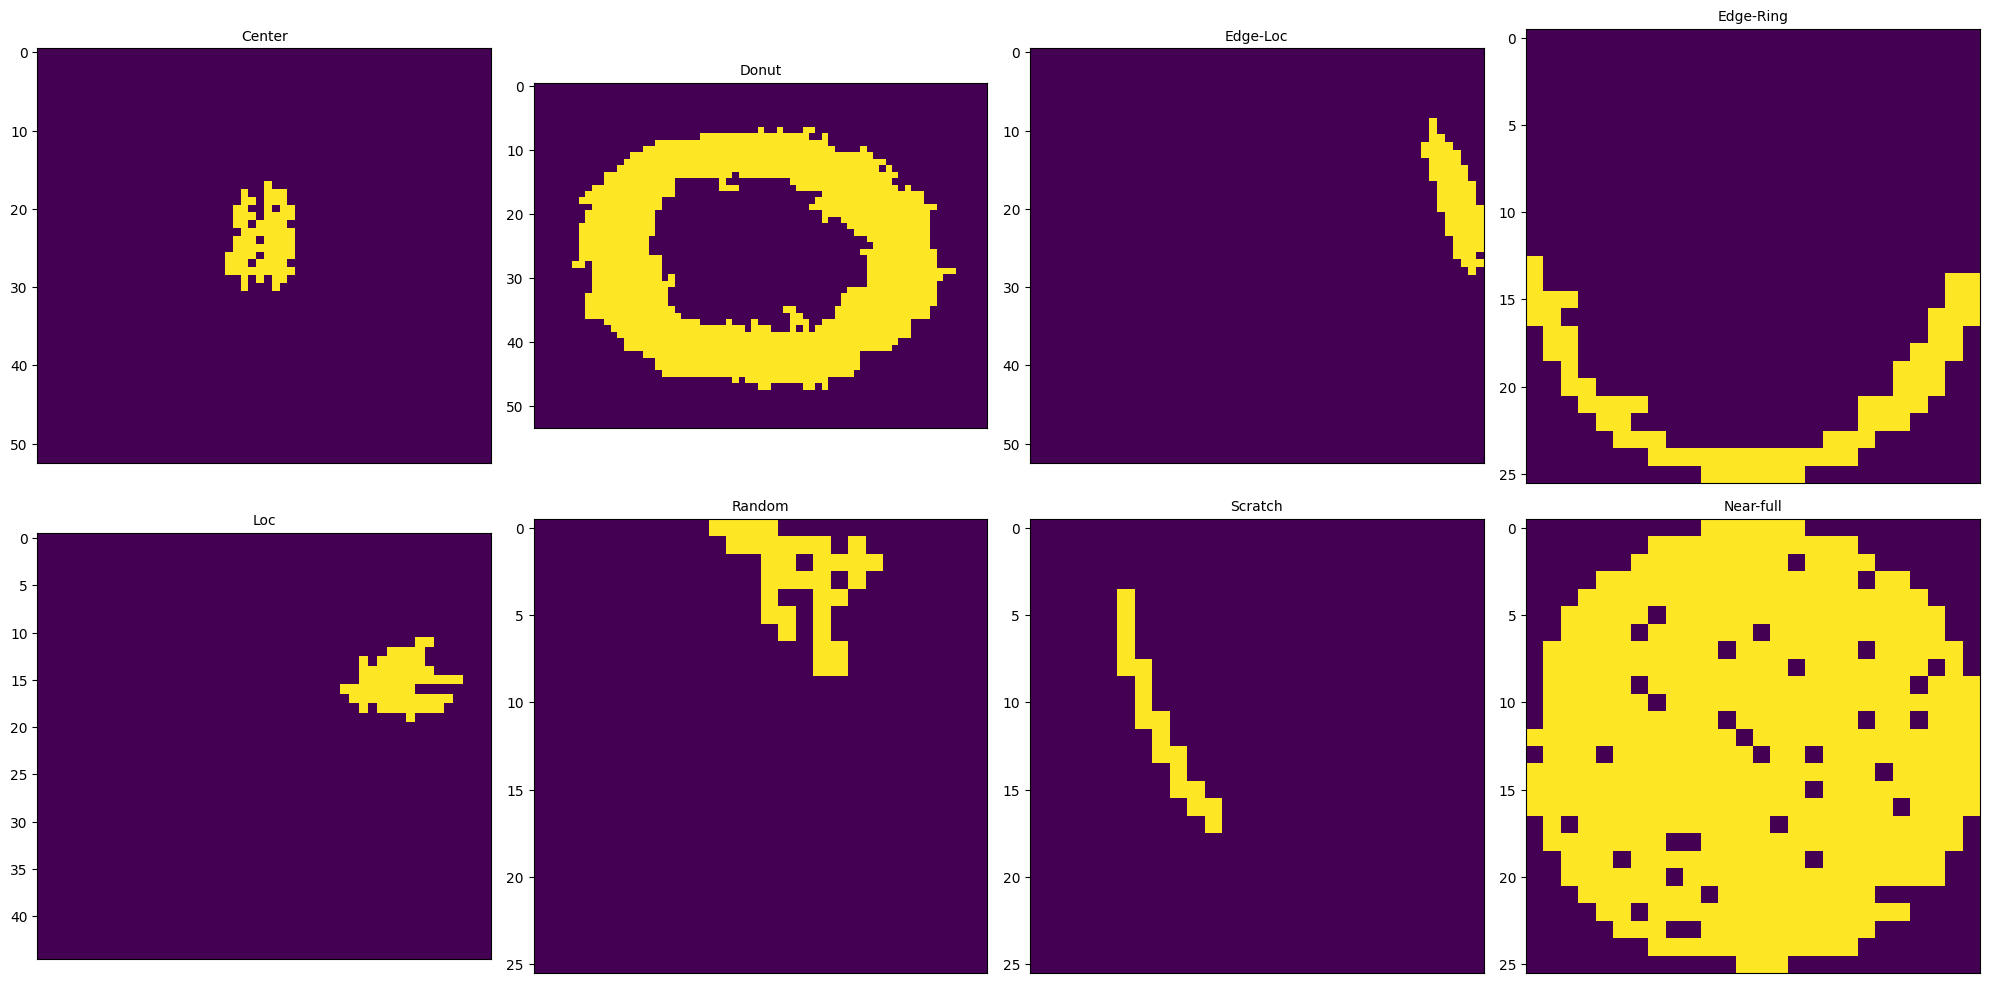

In [ ]:
x = [9,340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

fig, ax = plt.subplots(nrows = 2, ncols = 4,figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
  img = df_withpattern_copy.waferMap[x[i]]

  # zero_img: img와 같은 크기의 0으로 채운 배열
  # (목적: 필요한 영역만 값을 넣어서 시각화용 마스크로 쓰기 위해)
  zero_img = np.zeros(img.shape)

  # measure.label: scikit-image에서 가져온 함수 (이미지 분석용 라이브러리)
  # connectivity=1: 같은 조건
  # background=0: 0은 배경이므로 무시

  # measure.label: 결함이 있는 곳(0이 아닌 부분)을 찾아서 영역마다 번호(label)를 매겨줌.
  img_labels = measure.label(img, connectivity=1, background=0)

  # 레이블 번호가 1부터 시작하므로 -1을 해서 0부터 시작하게 정규화
  img_labels = img_labels-1

  # 결함이 없을 경우 처리

  # 결함이 하나도 없다면 레이블 최대값도 0일 거야 -> 그냥 0으로 설정
  if img_labels.max()==0:
    no_region = 0

  # stats.mode: 가장 많이 나온 레이블 번호를 뽑음 (가장 넓은 결함 영역 찾기)
  # img_labels > -1: 배경은 제외하고 (0부터 시작했으니 -1은 배경)
  # no_region: 가장 큰 결함 영역의 번호

  # stats.mode: SciPy의 통계 함수. 최대 빈도 값을 계산함
  else:
    info_region = stats.mode(img_labels[img_labels>-1], axis = None)

    # info_region은 2개의 값을 가진 결과 객체
    # info_region[0] → 최빈값 (가장 자주 나온 결함 번호들)
    # info_region[1] → 그 값이 몇 번 나왔는지 (빈도수)

    # info_region[0]은 결함 라벨 중 가장 넓은 영역의 레이블 번호가 담긴 배열
    no_region = info_region[0]

  # 결함 레이블(img_labels)이 no_region인 곳만 찾아서 값을 2로 바꿈
  # 0이면 배경, 2면 결함 영역 -> 색깔 차이로 시각화할 수 있음
  zero_img[np.where(img_labels==no_region)] = 2
  ax[i].imshow(zero_img) # zero_img를 해당 subplot 위치에 표시

  # failureType[x[i]][0][0]: 결함 유형이 이중 리스트 구조이기에 [0][0]으로 꺼낸 것
  ax[i].set_title(df_withpattern_copy.failureType[x[i]][0][0],fontsize=10)
  ax[i].set_xticks([]) # x축 눈금 제거
plt.tight_layout() # 그래프끼리 겹치지 않게 자동으로 레이아웃 조정
plt.show()

# neighbors=4는 예전 코드에서 쓰던 인자 현재 scikit-image의 measure.label() 함수에는 이 인자가 없다.
# 그러므로 img_labels = measure.label(img, connectivity=1, background=0)처럼 지워야 함.

# img: 레이블링할 이진 이미지

# connectivity=1:
# -> 상하좌우만 연결된 것으로 간주 (4-connected)
# -> connectivity=2면 대각선 포함 (8-connected)

# background=0: -> 값이 0인 픽셀은 결함이 아닌 배경으로 처리


In [ ]:
def cal_dist(img,x,y):
  dim0=np.size(img,axis=0) # dim0: 이미지의 세로 길이 (행의 수)
  dim1=np.size(img,axis=1) # dim1: 이미지의 가로 길이 (열의 수)

  # 중심점 (dim0/2, dim1/2)에서 입력점 (x, y)까지의 유클리드 거리
  # dist: 거리(distance) 계산 결과를 저장할 객체

  # 기본적인 2차원 유클리드 거리 공식: 거리 = sqrt((y2 - y1)^2 + (x2 - x1)^2)
  # (x, y)는 지금 우리가 계산할 결함의 중심 좌표
  # (dim0 / 2, dim1 / 2)는 이미지 중심 좌표
  dist = np.sqrt((x-dim0/2)**2+(y-dim1/2)**2)
  return dist

# fea_geom: 함수 이름 -> 기하적 특징(feature)을 추출하는 함수
def fea_geom(img):

  # img.shape[0]: 세로(행 수), img.shape[1]: 가로(열 수)
  # norm_area: 전체 이미지의 면적
  norm_area=img.shape[0]*img.shape[1]

  # norm_perimeter: 이미지의 대각선 길이(피타고라스 -> = √(높이² + 너비))
  norm_perimeter=np.sqrt((img.shape[0])**2+(img.shape[1])**2)

  # img에서 연결된 결함 영역들에 라벨 번호 붙임
  # connectivity=1: 4방향 연결 (상하좌우)
  # background=0: 배경은 값 0으로 처리함

  # 결함마다 1부터 시작하는 라벨 번호를 부여
  img_labels = measure.label(img, connectivity=1, background=0)

  # 라벨링된 결과 중 최댓값이 0이면 = 결함이 없음 (모든 픽셀이 0, 배경만 존재)
  if img_labels.max()==0:

    # 강제로 모든 배경(0)을 1로 바꿈 -> 결함이 있다고 가정
    img_labels[img_labels==0]=1

    # # 이후 분석을 위해 no_region = 0으로 설정 -> 라벨 번호가 1인 것을 0번째 인덱스로 처리
    # no_region = 0	-> 강제로 만든 결함 하나가 prop 리스트의 첫 번째(0번)에 있기 때문
    no_region = 0

  # 결함이 존재할 경우 (하나라도 0이 아닌 값)
  else:

    # img_labels > 0: 배경 제외
    # stats.mode(...): 가장 많이 나온 라벨 값 (= 가장 큰 결함 영역 라벨) -> 최빈값
    info_region = stats.mode(img_labels[img_labels>0], axis = None)

    # info_region[0] -> array([3]) : 최빈값, 가장 넓은 결함 영역의 라벨 번호
    # info_region[0][0] -> 3 : 최빈값의 실제 라벨 번호 자체

    # -1 하는 이유: 라벨 1부터 시작하는데 regionprops()는 인덱스 0부터 시작임 -> 그래서 라벨에 -1 함.
    # (regionprops는 0번째 인덱스가 라벨 1에 해당하기 때문)
    no_region = info_region[0]-1

  # regionprops()는 그 라벨 번호에 해당하는 정보를 인덱스 0부터 순서대로 저장한다.
  # prop: img_labels에서 각 결함 영역에 대한 속성 객체 리스트
  # prop[i]는 i번째 결함에 대한 크기, 둘레, 중심좌표 등 정보 포함

  # prop라는 리스트를 만들고, 그 리스트 안의 결함 순서를 결정
  # (img_labels 안에 있는 라벨들에 대해 각 결함 영역의 정보를 리스트로 반환)

  # measure.regionprops(): 라벨링된 이미지 (img_labels)를 받아서
  # 각 라벨(=결함)에 대한 속성 정보를 리스트로 반환해주는 함수
  # (prop = measure.regionprops(img_labels) 하기 전까지
  # img_labels는 결함에 번호만 매겨진 2D 배열(이미지)일 뿐)
  # 번호가 찍혀 있는 숫자 배열이지, 면적이나 중심좌표 같은 분석된 정보는 하나도 없음.
  prop = measure.regionprops(img_labels)

  # 선택된 결함의 면적을 전체 면적으로 나눠 정규화
  # 정규화 : 값의 크기를 일정한 범위로 바꿔주는 것(보통은 0~1 사이로 맞춤)
  # no_region(최빈값 라벨 - 1)의 픽셀 개수(면적) / 전체 면적
  prop_area = prop[no_region].area/norm_area

  # 선택된 결함의 둘레 길이 정규화
  prop_perimeter = prop[no_region].perimeter/norm_perimeter

  # 이미지나 행렬에서는 좌표가 (y, x) 또는 (행, 열) 순서로 표현되는 게 기본 규칙
  # local_centroid: 결함의 중심 좌표 (y, x)
  # cal_dist: 앞에서 정의한 함수 호출 -> 중심좌표가 이미지 중심에서 얼마나 떨어졌는지 거리 계산
  prop_cent = prop[no_region].local_centroid

  # img: 이미지 자체 (2차원 배열)
  # prop_cent[0]: 중심의 세로 좌표 (y좌표) = 행 번호
  # prop_cent[1]: 중심의 가로 좌표 (x좌표) = 열 번호
  prop_cent = cal_dist(img,prop_cent[0],prop_cent[1])

  # major_axis_length: 장축 길이
  # 결함의 장축(가장 긴 방향) 길이 정규화
  prop_majaxis = prop[no_region].major_axis_length/norm_perimeter

  # minor_axis_length: 단축 길이
  # 결함의 단축(짧은 방향) 길이 정규화
  prop_minaxis = prop[no_region].minor_axis_length/norm_perimeter

  # eccentricity: 타원의 찌그러진 정도를 나타내는 값(0 -> 완벽한 원, 1 -> 완전 찌그러진 선형)
  # 원처럼 둥글면	0에 가까움, 길쭉하면	1에 가까움
  prop_ecc = prop[no_region].eccentricity

  # solidity: 결함이 얼마나 빽빽하게 채워져 있는지를 측정(계산 공식: 면적 / 볼록 껍질(convex hull) 면적)
  # 1.0 -> 완전히 빈틈없이 채워진 도형
  # 0.7 등 -> 내부에 빈 공간이 많은 결함
  prop_solidity = prop[no_region].solidity

  # 결함의 6가지 기하학적 특징을 튜플(묶음) 형태로 리턴
  # (면적, 둘레, 장축 길이, 단축 길이, 타원의 찌그러진 정도, 결함이 얼마나 빽빽하게 채워져 있는지)
  return prop_area,prop_perimeter,prop_majaxis,prop_minaxis,prop_ecc,prop_solidity

# df_withpattern_copy: wafer 데이터프레임 (복사본)
# waferMap 컬럼(열)에는 각 웨이퍼의 결함 이미지 있음
# apply(fea_geom) -> 각 웨이퍼 이미지에 대해 fea_geom 함수를 적용

# 모든 웨이퍼에 대해 면적, 둘레, 장축, 단축, 찌그러짐, 빽빽함 계산하고
# 그걸 "fea_geom"이라는 새로운 열에 넣은 것
df_withpattern_copy['fea_geom'] =df_withpattern_copy.waferMap.apply(fea_geom)

# info_region[0]은 이미 스칼라값이기에 [0]을 또 하면 IndexError 발생
# no_region = info_region.mode[0]-1으로 수정


In [ ]:
# df_withpattern_copy의 340번째 웨이퍼에 대한 기하적 특징 6가지를 출력한다.

# df_withpattern_copy -> 패턴 결함이 있는 웨이퍼 데이터프레임 (원본의 복사본)
# .fea_geom -> 앞서 만든 결함의 기하적 특성(면적, 둘레, 장축 등)을 저장한 컬럼(열)
# [340] -> 340번째 웨이퍼를 가져옴 (0번부터 시작하니까 사실상 341번째 웨이퍼)
df_withpattern_copy.fea_geom[340] #donut

# [0] -> prop_area -> 결함 면적 비율 (전체 대비) -> 0.3088 (이미지의 약 30.88%가 결함)

# [1] -> prop_perimeter -> 결함 둘레 비율 -> 3.4633 (정규화된 둘레 (상대 단위))
# (결함의 둘레가 기준 대비 3.4633배 길다는 뜻 -> 둘레가 상당히 긴 결함 (예: 선형 결함, 엣지에 걸친 결함))

# [2] -> prop_majaxis -> 장축 길이 비율 -> 0.7465 (가장 긴 지름이 이미지 대각선의 약 74.6%)

# [3] -> prop_minaxis -> 단축 길이 비율 -> 0.5214 (짧은 지름이 대각선의 약 52.1%)

# [4] -> prop_ecc -> 찌그러짐 정도 -> 0.7156 (타원형, 꽤 길쭉함 (1에 가까울수록 찌그러짐))

# [5] -> prop_solidity -> 빽빽함 정도 -> 0.6103 (내부가 좀 헐렁함 (1에 가까우면 꽉 찬 모양))


(np.float64(0.30881585811163276),
 np.float64(3.4633305623147477),
 np.float64(0.7464951525564261),
 np.float64(0.5214489845402435),
 0.7155811292862498,
 np.float64(0.6103092783505155))

- 밀도기반 : 13개 (fea_reg_den(reg1~13))

- 라돈기반 : 40개
(평균 기반 -> cubic_inter_mean -> 20개),
(표준편차 기반 -> cubic_inter_std -> 20개), (총합 40개)

- 기하기반 : 6개 (fea_geom() 함수 결과)

- 전체 59개

In [ ]:
# df_withpattern_copy라는 데이터프레임을 복사해서 df_all이라는 새로운 데이터프레임을 생성
df_all=df_withpattern_copy.copy()

# df_all.shape[0] -> 행의 수, 즉 샘플 개수
# range(df_all.shape[0]) -> 0부터 전체 샘플 수까지 반복하라는 뜻
# 모든 샘플의 fea_reg 값을 하나씩 뽑는 거야.

# 밀도 기반으로 나눈 13개 영역에 대한 특성값
a=[df_all.fea_reg[i] for i in range(df_all.shape[0])] #13 -> "각 벡터는 13개의 값으로 구성되어 있다"

# 평균 기반으로 20개의 값으로 나눈 값
b=[df_all.fea_cub_mean[i] for i in range(df_all.shape[0])] #20 ->  "각 행마다 20개의 평균값 특징이 존재한다"

# 표준편차 기반으로 20개의 값으로 나눈 값
c=[df_all.fea_cub_std[i] for i in range(df_all.shape[0])] #20 -> "각 행마다 20개의 표준편차 특징이 존재한다"

# 기하 기반으로 나눈 6개의 값
d=[df_all.fea_geom[i] for i in range(df_all.shape[0])] #6 -> "각 행마다 6개의 기하학적 특징값이 있다"

# 전체 59개
# np.array(...) : 각각의 리스트들을 넘파이 배열로 변환함
# np.concatenate(...) : 여러 배열을 연결(concatenate)하는 함수
# axis=1 : 열 방향으로 붙인다는 뜻(가로 방향) -> 같은 행끼리 옆으로 이어붙임

# 리스트일 뿐이라 계산이나 벡터 연산이 안 됨 -> array로 넘파이 배열로 변환해야 수학적 연산 가능
# np.array(a) -> 넘파이 배열 (N행 × 13열)
# np.array(b) -> 넘파이 배열 (N행 × 20열)
# np.array(c) -> 넘파이 배열 (N행 × 20열)
# np.array(d) -> 넘파이 배열 (N행 × 6열)

# axis=1 -> n행으로 같은 행끼리 이어 붙이니 가로로 연결하면 열이 늘어나고, 행은 그대로 유지
# 행(N)은 그대로, 열이 13 + 20 + 20 + 6 = 59
fea_all = np.concatenate((np.array(a),np.array(b),np.array(c),np.array(d)),axis=1) #59 in total -> "총 59개의 특징값(열)을 가진다"

# 단순 복사(copy())는 표 형태(데이터프레임), 즉 전체 구조(표처럼 생긴 것)를 통째로 가져오는 것

# 특정 열(fea_reg, fea_cub_mean, fea_cub_std, fea_geom)을 각 샘플마다 하나씩 꺼내서 리스트로 정리
# a, b, c, d는 특정 열 안의 '리스트'들을 하나하나 꺼내서, 하나의 큰 리스트 묶음으로 만든 것

# df_all.shape[0] -> 샘플 수만큼 반복
# df_all.fea_reg[i] -> i번째 샘플의 밀도 기반 벡터(13개)
# df_all.fea_cub_mean[i] -> 평균 기반 벡터(20개)
# df_all.fea_cub_std[i] -> 표준편차 기반 벡터(20개)
# df_all.fea_geom[i] -> 기하 기반 벡터(6개)


In [ ]:
# df_all.shape[0]: 행 개수 = 샘플 수 -> 전체 샘플을 반복문

# df_all.failureNum[i]: i번째 샘플의 failureNum 값 하나 꺼냄
# failureNum 값은 레이블(label -> 단순한 "번호"가 아니라 "결함 유형" 전체를 구분해주는 코드
# 정상 vs 비정상(결함 있음) 정보도 포함되어 있으며 비정상일 경우 어떤 결함 유형인지도 포함되어 있다.
# (예: 0: 정상, 1: Center 결함, 2: Donut 결함... 이런 식)
# failureNum은 단순 번호가 아니라 결함 유무 + 결함 종류까지 다 담은 라벨

# [ ... for i in range(...) ] -> 한 줄로 전체 리스트 만들기
label=[df_all.failureNum[i] for i in range(df_all.shape[0])]

# 넘파이 배열 변환 -> 계산 및 모델 학습을 위해 np.array() 사용(수학적 계산이 가능한 형태로 만듬)
label=np.array(label)


- 어떤 알고리즘 사용할지는 자유이기 때문에, 우리는 SVM을 사용할 것이다.

- 보통 패턴인식, 자료분석을 위한 지도학습에서는 SVM을 많이 사용한다. 분류와 회귀분석이 주 기능이다.

In [ ]:
# Theano는 오래된 딥러닝 프레임워크 -> 요즘은 TensorFlow, PyTorch가 대세
# import theano <- 사용하지 않으므로 제거

# tensor는 Theano에서 사용하는 텐서 연산을 위한 모듈
# from theano import tensor as T <- 사용하지 않으므로 제거

# np_utils: Keras에서 라벨을 원-핫 인코딩할 때 사용하는 도구(np_utils.to_categorical() 등에서 쓰임)
# from keras.utils import np_utils <- 사용하지 않으므로 제거

# train_test_split: -> 데이터를 훈련용 / 테스트용으로 나누는 함수
# sklearn.cross_validation은 옛날 버전
# 현재는 sklearn.model_selection을 사용
from sklearn.model_selection import train_test_split

X = fea_all # 입력 데이터 (59개의 특성 벡터) -> 넘파이 배열 (샘플 수, 59)
y = label # 정답 데이터 (결함 번호) -> 정수값으로 구성된 넘파이 배열 (샘플 수,)

# Counter는 리스트나 배열 속 원소들의 개수 세기
from collections import  Counter

# X, y를 2개의 세트로 분리
# X_train, y_train: 학습용, X_test, y_test: 테스트용

# 랜덤 시드 고정(42) -> 실행할 때마다 결과가 같도록 설정
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# y_train에서 라벨별로 몇 개씩 있는지 출력 -> 학습 데이터에 각 클래스가 얼마나 분포되어 있는지 확인가능
print('Training target statistics: {}'.format(Counter(y_train)))

# 테스트 데이터의 라벨 분포 확인 -> 훈련과 테스트가 고르게 나뉘었는지 확인용
print('Testing target statistics: {}'.format(Counter(y_test)))

RANDOM_STATE =42 # 랜덤 시드를 상수로 따로 저장 -> 여러 곳에서 동일한 시드 사용할 때 편함

# Theano는 오래되었기에 PyTorch로 데이터 처리 후 SVM으로 분류


Training target statistics: Counter({np.int64(3): 7299, np.int64(2): 3860, np.int64(0): 3238, np.int64(4): 2677, np.int64(6): 905, np.int64(5): 640, np.int64(1): 404, np.int64(7): 116})
Testing target statistics: Counter({np.int64(3): 2381, np.int64(2): 1329, np.int64(0): 1056, np.int64(4): 916, np.int64(6): 288, np.int64(5): 226, np.int64(1): 151, np.int64(7): 33})


In [ ]:
# --- multicalss classification(다중 클래스 분류) ---#
# One-Vs-One(일대일 방식)


# LinearSVC는 선형 서포트 벡터 머신 (SVM) 분류기
# SVC는 커널을 사용할 수 있는 일반적인 SVM이지만, LinearSVC는 이름 그대로 선형 모델만 다룸
# 속도 빠름, 고차원 데이터에 적합
from sklearn.svm import LinearSVC

# sklearn.multiclass 모듈에서 One-vs-One 분류기
# 다중 클래스 문제를 여러 개의 이진 분류 문제로 분해하는 도구
# 내부적으로 SVM처럼 이진 분류 모델을 여러 개 만들어서 조합해줌.
from sklearn.multiclass import OneVsOneClassifier

# numpy는 과학 계산을 위한 핵심 파이썬 라이브러리
import numpy as np # 누락되어 있었던 경우 대비

# 최신 sklearn에서는 dtype 매개변수를 sum()에 직접 넣을 수 없음 -> astype으로 처리

# LinearSVC(random_state=RANDOM_STATE) -> 선형 SVM 모델을 만든 거고, random_state는 랜덤성 고정
# OneVsOneClassifier(...) -> 이 SVM 모델을 다중 클래스 문제를 해결할 수 있도록
# OvO(One-Vs-One) 방식으로 감싸는 래퍼(Wrapper)

# 래퍼(Wrapper) -> 어떤 기존 객체(함수, 모델 등)를 감싸서 기능을 추가하거나 사용법을 바꾸거나,
# 더 쉽게 쓸 수 있도록 만들어주는 도구

# .fit(X_train, y_train) -> 학습 진행

# 선형 SVM 분류기를 One-vs-One 방식으로 만들고, 훈련 데이터를 이용해서 학습한 것
clf2 = OneVsOneClassifier(LinearSVC(random_state = RANDOM_STATE)).fit(X_train, y_train)

# clf2를 이용해서 X_train, X_test 데이터에 대한 예측값을 만듬
# y_train_pred는 훈련 데이터에 대한 예측 결과를 담고 있는 넘파이 배열 객체

# y_test_pred는 테스트 세트에 대한 결과를 저장한 배열이야.
y_train_pred = clf2.predict(X_train)
y_test_pred = clf2.predict(X_test)

# 최신 방식: 정확도 계산 시 dtype 제거하고 astype으로 명시
# 예전에는 np.sum(..., dtype='float'), 지금은 .astype(float)을 명시적으로 붙임.

# .astype(float) -> NumPy 배열에서 사용 (np.ndarray 객체)
# .float() -> PyTorch 텐서에서만 사용 가능 (torch.Tensor 객체)

# y_train, y_train_pred가 넘파이 배열이기에 .float()는 절대 안 되며 반드시 .astype(float)을 사용

# (y_train == y_train_pred) -> 각 예측값이 정답과 일치하는지 True/False 배열 생성
# .astype(float) -> True는 1.0, False는 0.0으로 바꾸는 거야
# .sum() -> 맞춘 개수의 총합
# / X_train.shape[0] -> 전체 훈련 샘플 수로 나눠서 정확도 (accuracy) 계산
# (.shape[0]은 행의 수니까 샘플 수를 의미)
train_acc2 = (y_train == y_train_pred).astype(float).sum() / X_train.shape[0]
test_acc2 = (y_test == y_test_pred).astype(float).sum() / X_test.shape[0]

# 훈련 데이터, 테스트 데이터 정확도를 퍼센트(%)로 변환 후 출력
print('One-Vs-One Training acc: {}'.format(train_acc2*100)) #One-Vs-One Training acc: 80.36 -> 82.73
print('One-Vs-One Testing acc: {}'.format(test_acc2*100)) #One-Vs-One Testing acc: 79.04 -> 82.36

# y_train_pred의 앞부분 100개만 출력해서 예측값이 어떻게 나왔는지 확인
print("y_train_pred[:100]: ", y_train_pred[:100])

# 실제 정답값의 앞부분 100개도 같이 확인(예측이랑 실제값이 얼마나 맞는지 비교 가능)
print ("y_train[:100]: ", y_train[:100])


One-Vs-One Training acc: 82.73159517216155
One-Vs-One Testing acc: 82.3667711598746
y_train_pred[:100]:  [4 0 2 2 2 3 2 0 2 2 6 0 4 0 3 4 3 2 2 5 2 2 0 1 3 0 3 3 3 3 5 3 4 3 4 3 2
 4 3 2 2 2 3 3 0 6 3 5 2 3 0 3 2 2 2 0 3 3 1 0 4 2 3 3 3 3 4 3 0 3 2 4 0 2
 4 3 3 0 2 0 2 4 3 3 2 3 0 0 4 0 0 3 4 3 0 3 3 2 4 2]
y_train[:100]:  [5 0 4 2 0 3 2 0 2 2 6 0 4 0 3 0 6 2 2 5 2 4 0 5 3 0 3 3 3 3 2 3 4 3 4 3 3
 4 3 2 2 3 3 3 0 6 3 5 2 3 0 3 2 2 2 0 3 3 1 0 4 2 3 3 3 3 4 3 0 3 2 4 0 4
 2 3 3 0 2 0 2 4 3 3 4 3 0 0 6 0 0 3 4 3 0 3 3 2 4 2]


- 이것을 보니, training의 경우에는 80.3699%의 정확도가 나타남을 알 수 있다. -> 82.7315% 정확도 바뀜.

- testing의 경우에는 79.04%. -> 82.3667%


In [ ]:
# 조합, 곱, 반복 등 다양한 반복자 관련 기능을 제공하는 모듈
# (이 코드에서는 나중에 itertools.product()라는 반복기를 사용)
import itertools

# Scikit-learn의 metrics 모듈에서 confusion_matrix 함수를 가져옴.
# 정답과 예측을 비교해서 혼동행렬을 만들어주는 도구
from sklearn.metrics import confusion_matrix

# 그래프 그리는 대표적인 시각화 도구
# matplotlib.pyplot을 plt라는 생성한 이름으로 불러온 것
import matplotlib.pyplot as plt

# %matplotlib inline -> 코랩/노트북에서 그림을 결과창 아래에 자동 출력
%matplotlib inline

# 혼동행렬(Confusion Matrix): 분류 모델이 정답을 얼마나 잘 맞췄는지 구체적으로
# "뭘 맞추고, 뭘 틀렸는지"를 표(행렬) 형태로 보여주는 도구

# cm -> 입력값: 혼동행렬(confusion matrix), 보통 confusion_matrix(y_true, y_pred)로 만든 걸 넣음
# normalize=False	-> False면 값 그대로 표시, True면 각 행을 기준으로 비율(%)로 정규화
# title='Confusion matrix' -> 그래프 제목 기본값
# cmap=plt.cm.Blues -> 색상 스타일 지정. Blues는 파란 계열 컬러맵
def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

  # 이 함수는 혼동 행렬(confusion matrix)을 출력하고 시각화합니다.
  # 정규화를 적용하려면 `normalize=True`로 설정하면 됩니다.
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """

  # if normalize: -> 조건문: 정규화 하겠다고 했는지 확인
  if normalize:

    # 정규화: 각 행을 기준으로 값을 비율(%)로 바꿔줌

    # cm.astype('float') -> 넘파이 배열을 실수형으로 바꿈
    # cm.sum(axis=1) -> 각 행(= 실제 클래스)마다 전체 몇 개 샘플이 있었는지를 계산해서

    # [:, np.newaxis] -> 세로축(열 방향)으로 차원을 하나 추가 ((n,) → (n,1))
    # : -> 모든 원소 그대로 유지 (행은 유지)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix") # 정규화된 혼동 행렬
  else:
    print('Confusion matrix, without normalization') # 정규화 없는 혼동 행렬

  print(cm) # 주석 처리된 코드. 혼동 행렬 자체를 텍스트로 출력하고 싶을 때 쓰면 됨.

  # plt.imshow() -> 2차원 데이터를 이미지로 표현
  # interpolation='nearest' -> 픽셀 사이를 부드럽게 하지 않고, 가장 가까운 값으로 유지 (계단식 표현)
  # cmap=cmap -> 색상 맵 적용. 기본은 Blues
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title) # 그래프 제목 지정
  plt.colorbar() # 색상 값 범례(옆에 색 막대) 추가

  # fmt	-> 숫자를 셀 안에 표시할 때 형식 지정 -> '.2f': 소수점 둘째 자리까지, 'd': 정수로 표시
  fmt = '.2f' if normalize else 'd' # 값 표시 형식 지정

  # thresh -> 색상 기준 값: 텍스트 색을 흰색/검정으로 나눌 때 기준이 되는 임계값

  # 셀의 값(cm[i,j])이 크면 -> 밝은 배경이니 글씨는 흰색
  # 셀의 값이 작으면 -> 어두운 배경이니 글씨는 검정색

  # 2로 나누는 이유: "최댓값의 절반"을 기준으로, 밝고 어두운 셀을 나누기 위해서
  thresh = cm.max() / 2. # 색 대비 기준 임계값

  # 행과 열을 반복하면서 각각의 셀에 숫자 텍스트 표시

  # itertools.product(...) -> 모든 행(i)과 열(j)의 조합 반복 (2중 for문처럼 작동)
  # range를 모든 조합으로 만들어줌

  # cm.shape[0] -> 혼동행렬의 행 개수 (즉, 실제 클래스 수)
  # cm.shape[1] -> 혼동행렬의 열 개수 (즉, 예측된 클래스 수)
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

    # j -> x축 위치 (열 index), i -> y축 위치 (행 index)
    # plt.text(j, i, ...) -> 셀 중앙에 숫자 표시
    # format(cm[i,j], fmt) -> 위에서 설정한 형식으로 숫자 변환

    # horizontalalignment="center" -> 글자를 셀 안에서 가운데 정렬(center alignment)

    # 셀 값 cm[i, j]이 임계값(thresh)보다 크면: 배경이 진할 거라서 글씨는 흰색
    # 그 외엔 배경이 연할 거라서 글씨는 검정색
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout() # 그래프 요소 간 여백 자동 조정
  plt.ylabel('True label') #  Y축 라벨: 실제 값
  plt.xlabel('Predicted label') # X축 라벨: 예측 값


Confusion matrix, without normalization
[[ 982    5    7    1   57    2    1    1]
 [   4  120    3    0   24    0    0    0]
 [  11    0  951  185  135    9   38    0]
 [   1    0  137 2215    6    1   21    0]
 [  72   16  211    8  591    1   17    0]
 [   3    2    6    0   12  201    0    2]
 [   8    2   60   14   41    1  162    0]
 [   0    0    0    0    0    0    0   33]]
Normalized confusion matrix
[[9.30e-01 4.73e-03 6.63e-03 9.47e-04 5.40e-02 1.89e-03 9.47e-04 9.47e-04]
 [2.65e-02 7.95e-01 1.99e-02 0.00e+00 1.59e-01 0.00e+00 0.00e+00 0.00e+00]
 [8.28e-03 0.00e+00 7.16e-01 1.39e-01 1.02e-01 6.77e-03 2.86e-02 0.00e+00]
 [4.20e-04 0.00e+00 5.75e-02 9.30e-01 2.52e-03 4.20e-04 8.82e-03 0.00e+00]
 [7.86e-02 1.75e-02 2.30e-01 8.73e-03 6.45e-01 1.09e-03 1.86e-02 0.00e+00]
 [1.33e-02 8.85e-03 2.65e-02 0.00e+00 5.31e-02 8.89e-01 0.00e+00 8.85e-03]
 [2.78e-02 6.94e-03 2.08e-01 4.86e-02 1.42e-01 3.47e-03 5.62e-01 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+

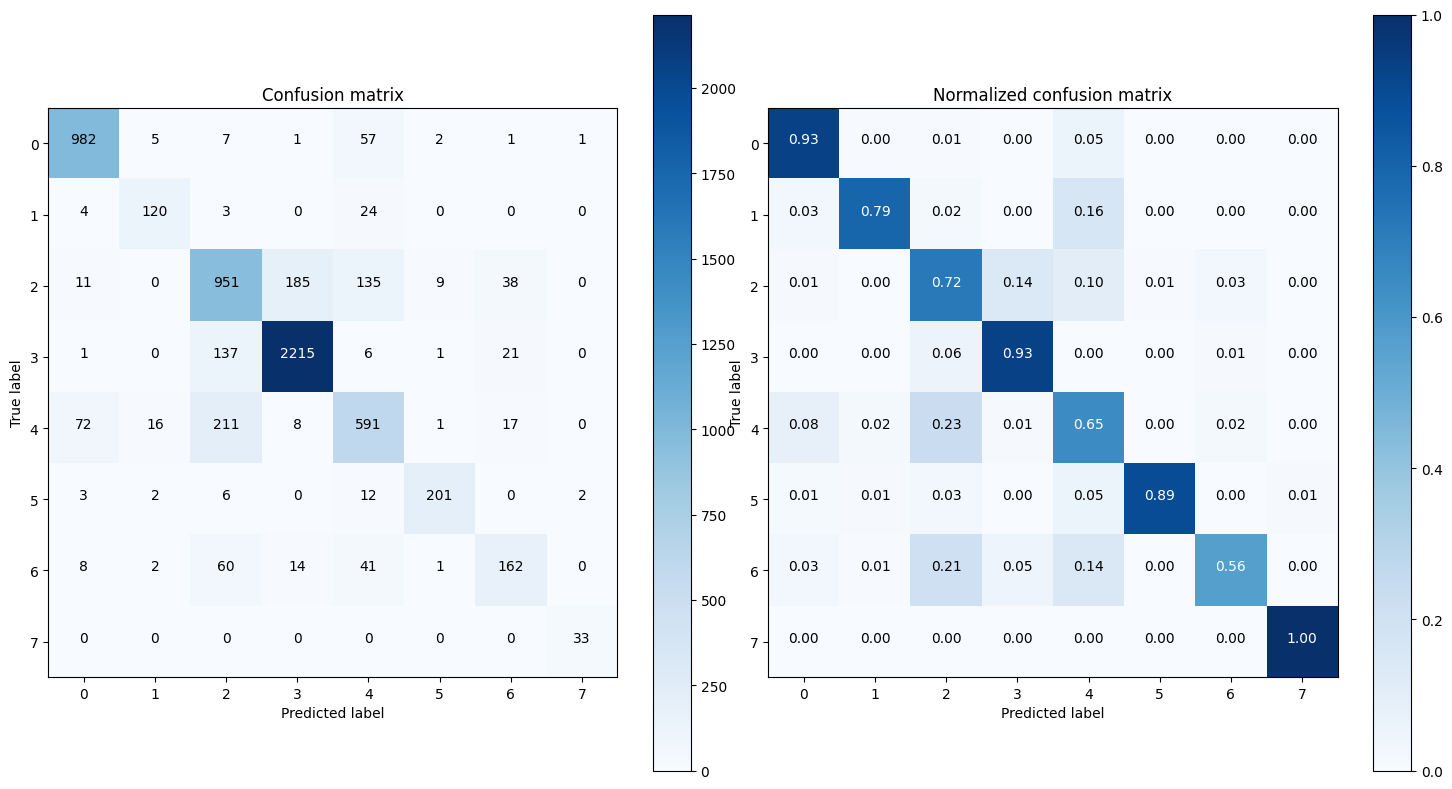

In [ ]:
# Compute confusion matrix(혼동 행렬 계산)


# confusion_matrix() -> sklearn.metrics에서 가져온 도구.
# 실제값과 예측값을 비교해서 혼동행렬(정답/오답 개수 표)을 만듬.

# y_test -> 실제 정답 라벨 (예: [0, 1, 2, 2, 0])
# y_test_pred -> 예측된 라벨
cnf_matrix = confusion_matrix(y_test, y_test_pred)

# np.set_printoptions(...) -> 넘파이 배열을 화면에 출력할 때 소수점 몇 자리까지 보여줄지 설정
# precision=2 -> 소수점 둘째 자리까지 출력
np.set_printoptions(precision=2)

# gridspec -> matplotlib에서 서브플롯(subplot)을 격자(grid) 구조로 정교하게 나눌 수 있게 해주는 도구
# (1x2로 나누어서 왼쪽에 원본 혼동행렬, 오른쪽에 정규화된 혼동행렬을 나란히 보여주기 위해 사용함.)
from matplotlib import gridspec

# plt.figure(...) -> 그림판 전체를 하나 만들기 위한 명령
# figsize=(15,8) -> 가로 15인치, 세로 8인치 크기로 설정
# (15x8 사이즈의 큰 그림판 하나 만들기)
fig = plt.figure(figsize=(15, 8))

# gridspec.GridSpec(1, 2) -> subplot을 1행 2열로 나눔
# width_ratios=[1, 1] -> 두 개 칸의 너비를 1:1로 균등하게
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

## Plot non-normalized confusion matrix (정규화되지 않은 혼동행렬을 시각화함)
## 즉, 그냥 개수 그대로 표시하는 혼동행렬


# gs[0] -> 앞서 만든 subplot 중 왼쪽 칸을 의미
# plt.subplot(...) -> 지금부터 그리는 그래프는 이 위치에 그려라! 라는 명령
plt.subplot(gs[0])

# plot_confusion_matrix() 함수를 호출
# normalize=False는 기본값이라 생략 -> 정규화 안 된 원본 혼동행렬을 그림
# cnf_matrix라는 혼동행렬을 넣고 -> title='Confusion matrix'라는 제목을 붙임
plot_confusion_matrix(cnf_matrix, title='Confusion matrix')

## Plot normalized confusion matrix (정규화된 혼동행렬을 시각화함)
## 즉, 각 행을 기준으로 비율(%)로 바꿔서 표시함


# gs[1] -> 오른쪽 칸에 그래프 그릴 준비
# 오른쪽 subplot 위치 지정
plt.subplot(gs[1])

# normalize=True -> 각 행 기준으로 정규화 (예: 70%, 20% 이런 식으로 비율로 바꿈)
# title='Normalized confusion matrix' -> 제목도 다르게 붙여줌
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

# 지금까지 그린 그래프 출력
plt.show()

# Confusion matrix (비정규화)
# 실제 개수 기반, 각 셀에 얼마나 많이 맞췄는지/틀렸는지 개수가 적혀있음

# 예시:
# cm[3,3] = 2215 -> 실제 클래스 3을 예측도 3으로 맞춘 횟수 -> 아주 많이 맞췄다(색이 진하다)
# cm[2,4] = 135 -> 실제 클래스 2를 예측을 4로 한 경우 -> 꽤 많이 틀렸다(주의해야 할 오답)

# Normalized confusion matrix (정규화)
# 비율(%) 기반, 각 행을 1.0(=100%)으로 나눈 뒤 예측이 어디에 분포됐는지를 보는 그래프

# 예시:
# cm[3,3] = 0.93 -> 실제 클래스 3인 것 중 93%는 3으로 정확히 예측됨
# cm[2,3] = 0.14, cm[2,4] = 0.10 -> 클래스 2를 자주 3이나 4로 틀리게 예측함 -> 오답 분포가 있다는 뜻

# 해석 순서:
# 1단계: 대각선(맞춘 부분)이 진한가?
# 대각선이 진할수록 정확히 맞춘 비율이 높음

# 예: cm[0,0] = 0.93, cm[3,3] = 0.93 → 좋은 분류


# 2단계: 비대각선(대각선이 아닌 셀들 -> 틀린 부분)에 진한 칸이 있는가?
# 진하면 그쪽으로 자주 잘못 분류함 (주의!)

# 예: cm[2,3] = 0.14, cm[2,4] = 0.10 -> 클래스 2는 3과 4로 자주 틀림 → 이 셋은 서로 헷갈리는 클래스


# 3단계: 특정 클래스의 전체 정확도는?
# 오른쪽 그림에서 각 행의 대각선 값이 클래스별 정확도

# 클래스	정확도 (예측 일치율)
#   0	      0.93
#   1     	0.79
#   2	      0.72
#   3     	0.93
#   4	      0.65 ← 다소 낮음
#   5	      0.89
#   6     	0.56 ← 제일 낮음
#   7	      1.00 ← 완벽히 맞춤 (건수 적음)

# 클래스 6은 제일 헷갈려 하고,
# 클래스 4도 0.65로 주의 필요,
# 클래스 7은 완벽하지만 건수(33건)가 적음


- 알고리즘을 수정하거나 앙상블같이 다른 모델을 결합하면 아마도 정확도를 더 향상 시킬 수 있을것!